In [ ]:
#必要ライブラリのインポート
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.special import softmax
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.ticker as ptick
import matplotlib.font_manager as fm
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap
import seaborn as sns
import mpl_toolkits
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sklearn
import sklearn.cluster
import sklearn.metrics
from sklearn import preprocessing
import rich.table
import xarray as xr
import rioxarray as rxr

import geopandas as gpd
import geoplot as gplt
import cartopy, fiona, shapely, pyproj, rtree, pygeos
import cv2
import rasterio as rio
from rasterio import plot
from rasterio.plot import show, plotting_extent
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.features import geometry_mask, shapes
from shapely.geometry import MultiPolygon, Polygon, shape
import rasterstats
import earthpy.spatial as es
import earthpy.plot as ep
import libpysal

import os
import zipfile
import glob
import shutil

import urllib
from satsearch import Search
from pystac_client import Client
from PIL import Image
import requests
import io
from pystac_client import Client
import warnings
# from tqdm import tqdm
from tqdm.notebook import tqdm

import pymc as pm
import jax
import arviz as az
import pytensor.tensor as pt
import pytensor
import gc
import optuna.integration.lightgbm as opt_lgb

# CPU Multi
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'
print(jax.default_backend())
print(jax.devices("cpu"))

# 日本語フォント読み込み
jpn_fonts=list(np.sort([ttf for ttf in fm.findSystemFonts() if 'ipaexg' in ttf or 'msgothic' in ttf or 'japan' in ttf or 'ipafont' in ttf]))
jpn_font=jpn_fonts[0]
prop = fm.FontProperties(fname=jpn_font)
print(jpn_font)
plt.rcParams['font.family'] = prop.get_name() #全体のフォントを設定
plt.rcParams['figure.dpi'] = 250

pd.options.display.float_format = '{:.5f}'.format
sns.set()

In [ ]:
# データをダウンロードするかどうか
DOWNLOAD = False

In [ ]:
# 取得範囲を指定するための関数を定義
def selSquare(lon, lat, delta_lon, delta_lat):
    c1 = [lon + delta_lon, lat + delta_lat]
    c2 = [lon + delta_lon, lat - delta_lat]
    c3 = [lon - delta_lon, lat - delta_lat]
    c4 = [lon - delta_lon, lat + delta_lat]
    geometry = {"type": "Polygon", "coordinates": [[ c1, c2, c3, c4, c1 ]]}
    return geometry

# 茨城県周辺の緯度経度をbbox内へ
geometry = selSquare(140.0363, 35.9632, 0.06, 0.02)
timeRange = '2018-01-01/2023-12-31' # 取得時間範囲を指定

In [ ]:
# STACサーバに接続し、取得範囲・時期やクエリを与えて取得するデータを絞る
# sentinel:valid_cloud_coverを用いて、雲量の予測をより確からしいもののみに限定している
if DOWNLOAD:
  api_url = 'https://earth-search.aws.element84.com/v0'
  collection = "sentinel-s2-l2a-cogs"  # Sentinel-2, Level 2A (BOA)
  s2STAC = Client.open(api_url, headers=[])
  s2STAC.add_conforms_to("ITEM_SEARCH")

  s2Search = s2STAC.search (
      intersects = geometry,
      datetime = timeRange,
      query = {"eo:cloud_cover": {"lt": 11}, "sentinel:valid_cloud_cover": {"eq": True}},
      collections = collection)

  s2_items = [i.to_dict() for i in s2Search.get_items()]
  print(f"{len(s2_items)} のシーンを取得")

In [ ]:
# product_idやそのgeometryの情報がまとまったdf作成
if DOWNLOAD:
  items = s2Search.get_all_items()
  df = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:32654")
  dfSorted = df.sort_values('eo:cloud_cover').reset_index(drop=True)
  # epsgの種類
  print('epsg', dfSorted['proj:epsg'].unique())
  display(dfSorted.head(3))
  # 雲量10以下の日時
  print(np.sort(dfSorted[dfSorted['eo:cloud_cover']<=10]['datetime'].unique()))

In [ ]:
# 2018‐2023各年の同じ時期のproduct_id一覧取得
if DOWNLOAD:
  df_selected = dfSorted[dfSorted['datetime'].isin(['2018-04-28T01:36:01Z', '2019-05-08T01:37:21Z', '2020-05-02T01:37:21Z', '2021-04-22T01:37:12Z', '2022-04-12T01:37:20Z', '2023-04-27T01:37:18Z'])].copy().sort_values('datetime').iloc[[0,2,3,4,5,6],:]
  display(df_selected['sentinel:product_id'].to_list())

In [ ]:
# 各productのデータURLやtifファイル名の一覧取得
if DOWNLOAD:
  selected_item = [x.assets for x in items if x.properties['sentinel:product_id'] in (df_selected['sentinel:product_id'].to_list())]
  selected_item = sorted(selected_item, key=lambda x:x['thumbnail'].href)

In [ ]:
# thumbnailで撮影領域確認
if DOWNLOAD:
  plt.rcParams['font.family'] = prop.get_name() #全体のフォントを設定
  fig = plt.figure(figsize=(7,3))
  for ix, sitm in enumerate(selected_item):
    thumbImg = Image.open(io.BytesIO(requests.get(sitm['thumbnail'].href).content))
    ax = plt.subplot(2,3,ix+1)
    ax.imshow(thumbImg)
    plt.setp(ax.get_xticklabels(), fontsize=4)
    plt.setp(ax.get_yticklabels(), fontsize=4)
    ax.set_title('撮影日時 : '+'-'.join(sitm['thumbnail'].href.split('/')[-5:-2]), fontsize=4)
    ax.grid(False)
  plt.tight_layout()
  plt.show()

In [ ]:
# Sentinel-2のバンド情報を表で示す
if DOWNLOAD:
  table = rich.table.Table("Asset Key", "Description")
  for asset_key, asset in selected_item[0].items():
    table.add_row(asset_key, asset.title)

  display(table)

In [ ]:
# URLからファイルをダウンロードする関数を定義
# 引用：https://note.nkmk.me/python-download-web-images/
def download_file(url, dst_path):
    try:
        with urllib.request.urlopen(url) as web_file, open(dst_path, 'wb') as local_file:
            local_file.write(web_file.read())
    except urllib.error.URLError as e:
        print(e)

def download_file_to_dir(url, dst_dir):
    download_file(url, os.path.join(dst_dir, url.split('/')[-2]+'_'+os.path.basename(url)))

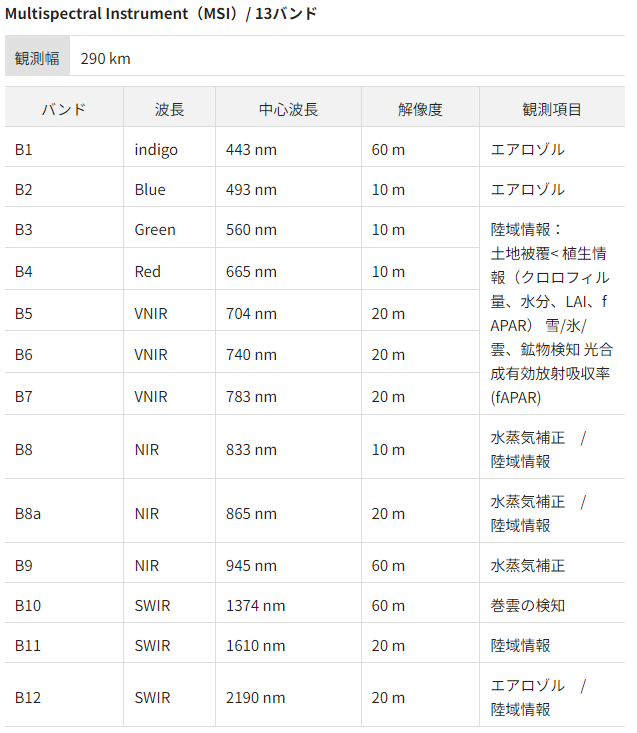

In [ ]:
# 画像を保存するディレクトリの作成
dst_dir = 'content/drive/MyDrive/satelite/s2Bands'  # Google Colabでは'/content~~'が正
os.makedirs(dst_dir, exist_ok=True)
# tifファイルをダウンロード(時間かかる)
if DOWNLOAD:
  # 取得するバンドの選択
  bandLists = ['B12','B11','B08','B04','B03','B02'] # SWIR2, SWIR1, NIR, RED, GREEN, BLUE

  # 画像のURL取得
  file_url = []
  for sitm in selected_item:
    [file_url.append(sitm[band].href) for band in bandLists if file_url.append(sitm[band].href) is not None]

  # 画像のダウンロード
  [download_file_to_dir(link, dst_dir) for link in file_url if download_file_to_dir(link, dst_dir) is not None]

In [ ]:
# ダウンロードファイルリスト（撮影日時順）
display(sorted(os.listdir(dst_dir), key=lambda x:(x.split('_54SVE_')[-1])))

In [ ]:
# 試しにバンド11のデータを1つ可視化
src = rio.open(os.path.join(dst_dir,'S2B_54SVE_20180428_0_L2A_B11.tif'))
fig = plt.figure(figsize=(2, 2))
ax=plt.subplot(1,1,1)
retted = show(src.read(), transform=src.transform, cmap='RdYlGn', ax=ax, vmax=np.quantile(src.read(1), q=0.99))
img = retted.get_images()[0]
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cax = divider.append_axes('right', '5%', pad='3%')
cbar = plt.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=4)
plt.setp(ax.get_xticklabels(), fontsize=4)
plt.setp(ax.get_yticklabels(), fontsize=4)
ax.yaxis.offsetText.set_fontsize(4)
ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.grid(False)
plt.show()

# 試しにバンド12のデータを1つ可視化
src = rio.open(os.path.join(dst_dir,'S2B_54SVE_20180428_0_L2A_B12.tif'))
fig = plt.figure(figsize=(2, 2))
ax=plt.subplot(1,1,1)
retted = show(src.read(), transform=src.transform, cmap='RdYlGn', ax=ax, vmax=np.quantile(src.read(1), q=0.99))
img = retted.get_images()[0]
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cax = divider.append_axes('right', '5%', pad='3%')
cbar = plt.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=4)
plt.setp(ax.get_xticklabels(), fontsize=4)
plt.setp(ax.get_yticklabels(), fontsize=4)
ax.yaxis.offsetText.set_fontsize(4)
ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.grid(False)
plt.show()

In [ ]:
# ラスターデータリスト読み込み
getList = sorted(list(glob.glob(dst_dir+'/S2*')), key=lambda x:(x.split('_54SVE_')[-1]))
display(getList)

In [ ]:
# ラスターデータをベクターデータの範囲にcropして保存
s2Output = 'content/drive/MyDrive/satelite/s2Output'  # Google Colabでは'/content~~'が正
os.makedirs(s2Output, exist_ok=True) # outputデータ保存ディレクトリ
if DOWNLOAD:
  band_paths_list = es.crop_all(list(getList), s2Output, re_shape_tsukuba_mirai_2RasterCrs, overwrite=True)
# cropしたラスターデータリスト
band_paths_list = sorted(list(glob.glob(s2Output+'/S2*')), key=lambda x:(x.split('_54SVE_')[-1]))  # 撮影日時順にソート
display(band_paths_list)

In [ ]:
# cropしたラスターデータ（つくばみらい市）をベクターデータと共に試しに可視化
src = rio.open(band_paths_list[3])  # Band 8
fig = plt.figure(figsize=(2, 2))
ax=plt.subplot(1,1,1)
retted = show(src.read(), transform=src.transform, cmap='coolwarm', ax=ax, vmin=0, vmax=3500)
im = retted.get_images()[0]
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cax = divider.append_axes("right", '5%')
cbar = fig.colorbar(im, ax=ax, cax=cax, shrink=0.6, extend='both')
cbar.ax.tick_params(labelsize=4)
re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=1, ax=ax, linewidth=0.2)
plt.setp(ax.get_xticklabels(), fontsize=4)
plt.setp(ax.get_yticklabels(), fontsize=4)
ax.yaxis.offsetText.set_fontsize(4)
ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_title('_'.join(os.path.basename(src.name).split('_')[-5:-1]), fontsize=4)
ax.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# 各バンドのtifファイルのリスト
B04s = sorted(list(glob.glob(os.path.join(s2Output,'S2*B04_crop.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
B08s = sorted(list(glob.glob(os.path.join(s2Output,'S2*B08_crop.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
B11s = sorted(list(glob.glob(os.path.join(s2Output,'S2*B11_crop.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
B12s = sorted(list(glob.glob(os.path.join(s2Output,'S2*B12_crop.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))

B03s = sorted(list(glob.glob(os.path.join(s2Output,'S2*B03_crop.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
B02s = sorted(list(glob.glob(os.path.join(s2Output,'S2*B02_crop.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
print(B04s)
print(B08s)
print(B11s)
print(B12s)
print(B03s)
print(B02s)

In [ ]:
if DOWNLOAD:
    # バンドごとに分解能が違う場合があるので、リサンプリングしてグリッドを合わせる
    # 10m分解能のバンドを20m分解能のバンド11のグリッドに合わせる
    for num, (b04, b08, b11, b12, b03, b02) in enumerate(zip(B04s, B08s, B11s, B12s, B03s, B02s)):
      print('#####', os.path.basename(b08).split('_')[2], '#####')
      riod04 = rio.open(b04)
      riod08 = rio.open(b08)
      riod11 = rio.open(b11)
      riod12 = rio.open(b12)
      riod03 = rio.open(b03)
      riod02 = rio.open(b02)
      bounds = riod04.bounds
      # print(riod08.read().shape)
      # print(riod11.read().shape)
      # ラスターデータをリサンプリングしてバンド11に合わせる
      riod08_resampling = riod08.read(out_shape=(riod08.count,int(riod11.height),int(riod11.width)),
                                      resampling=Resampling.cubic)
      riod04_resampling = riod04.read(out_shape=(riod04.count,int(riod11.height),int(riod11.width)),
                                      resampling=Resampling.cubic)
      riod03_resampling = riod03.read(out_shape=(riod03.count,int(riod11.height),int(riod11.width)),
                                      resampling=Resampling.cubic)
      riod02_resampling = riod02.read(out_shape=(riod02.count,int(riod11.height),int(riod11.width)),
                                      resampling=Resampling.cubic)
    
      print('B11', riod11.read().shape, riod11.read().shape, sep='-->')
      print('B12', riod12.read().shape, riod12.read().shape, sep='-->')
      print('B04', riod04.read().shape, riod04_resampling.shape, sep='-->')
      print('B08', riod08.read().shape, riod08_resampling.shape, sep='-->')
      print('B03', riod03.read().shape, riod03_resampling.shape, sep='-->')
      print('B02', riod02.read().shape, riod02_resampling.shape, sep='-->')
    
      out_meta = riod11.meta
      out_meta.update({'dtype':rio.float32})
        
      fname11 = 'resampling_'+os.path.basename(riod11.name)
      with rio.open(os.path.join(s2Output, fname11), "w", **out_meta) as dest:
        dest.write(riod11.read().astype(rio.float32))
    
      fname12 = 'resampling_'+os.path.basename(riod12.name)
      with rio.open(os.path.join(s2Output, fname12), "w", **out_meta) as dest:
        dest.write(riod12.read().astype(rio.float32))
    
      fname08 = 'resampling_'+os.path.basename(riod08.name)
      with rio.open(os.path.join(s2Output, fname08), "w", **out_meta) as dest:
        dest.write(riod08_resampling.astype(rio.float32))
    
      fname04 = 'resampling_'+os.path.basename(riod04.name)
      with rio.open(os.path.join(s2Output, fname04), "w", **out_meta) as dest:
        dest.write(riod04_resampling.astype(rio.float32))
    
      fname03 = 'resampling_'+os.path.basename(riod03.name)
      with rio.open(os.path.join(s2Output, fname03), "w", **out_meta) as dest:
        dest.write(riod03_resampling.astype(rio.float32))
    
      fname02 = 'resampling_'+os.path.basename(riod02.name)
      with rio.open(os.path.join(s2Output, fname02), "w", **out_meta) as dest:
        dest.write(riod02_resampling.astype(rio.float32))

In [ ]:
# 座標の基準とするラスターデータ読み込み
raster_crs = rio.open(os.path.join(dst_dir,'S2B_54SVE_20180428_0_L2A_B11.tif'))
raster_profile = raster_crs.profile

# 小地域区分のベクターデータ（from e-Stat）を読み込みcrsをラスターデータに合わせる
shape_path = "content/drive/MyDrive/satelite/ibrakiPolygon/"  # Google Colabでは'/content~~'が正
os.makedirs(shape_path, exist_ok=True)
part_in_shape = gpd.read_file(os.path.join(shape_path, "r2ka08235.shp"), encoding="shift-jis")[['PREF_NAME', 'CITY_NAME', 'S_NAME', 'AREA', 'PERIMETER', 'JINKO', 'SETAI', 'geometry']]
re_shape_tsukuba_mirai_2RasterCrs = part_in_shape.to_crs(raster_profile["crs"])  #crs合わせ
print(re_shape_tsukuba_mirai_2RasterCrs.shape)
# 同じ小地域がさらに細かく分かれている場合があるので、小地域単位でグループ化しておく
re_shape_tsukuba_mirai_2RasterCrs = re_shape_tsukuba_mirai_2RasterCrs.dissolve(['PREF_NAME', 'CITY_NAME', 'S_NAME'], aggfunc='sum', as_index=False)
print(re_shape_tsukuba_mirai_2RasterCrs.shape)  # 特定の小地域が統合されレコード数が減る
display(re_shape_tsukuba_mirai_2RasterCrs)

In [ ]:
# 茨城県を含む土壌分類のデータをダウンロードしておく(国土数値情報ダウンロードサイト 土地利用細分メッシュデータ4つ)
if DOWNLOAD:
    print(1)
    ground_truth = gpd.read_file(os.path.join(shape_path, "L03-b-21_5340-tky.shp"), encoding="shift-jis")
    ground_truth = ground_truth.to_crs(raster_profile["crs"])  #crs合わせ
    ground_truth = gpd.overlay(re_shape_tsukuba_mirai_2RasterCrs, ground_truth, how='intersection')  # クロップ
    print(2)
    ground_truth2 = gpd.read_file(os.path.join(shape_path, "L03-b-21_5339-tky.shp"), encoding="shift-jis")
    ground_truth2 = ground_truth2.to_crs(raster_profile["crs"])  #crs合わせ
    ground_truth2 = gpd.overlay(re_shape_tsukuba_mirai_2RasterCrs, ground_truth2, how='intersection')
    print(3)
    ground_truth3 = gpd.read_file(os.path.join(shape_path, "L03-b-21_5440-tky.shp"), encoding="shift-jis")
    ground_truth3 = ground_truth3.to_crs(raster_profile["crs"])  #crs合わせ
    ground_truth3 = gpd.overlay(re_shape_tsukuba_mirai_2RasterCrs, ground_truth3, how='intersection')
    print(4)
    ground_truth4 = gpd.read_file(os.path.join(shape_path, "L03-b-21_5439-tky.shp"), encoding="shift-jis")
    ground_truth4 = ground_truth4.to_crs(raster_profile["crs"])  #crs合わせ
    ground_truth4 = gpd.overlay(re_shape_tsukuba_mirai_2RasterCrs, ground_truth4, how='intersection')

In [ ]:
# 4つのデータを連結
if DOWNLOAD:
    ground_truth_2RasterCrs_concat = pd.concat([ground_truth
                                                , ground_truth2
                                                , ground_truth3
                                                , ground_truth4]).reset_index(drop=True)
    ground_truth_2RasterCrs_concat.to_file(os.path.join(shape_path, "ground_truth_2RasterCrs_concat.shp"), encoding="shift-jis")

In [ ]:
# 連結した土壌分類でデータ読み込み
ground_truth_2RasterCrs_concat = gpd.read_file(os.path.join(shape_path, "ground_truth_2RasterCrs_concat.shp"), encoding="shift-jis")
display(ground_truth_2RasterCrs_concat)

In [ ]:
area_use_categories = {'0100':'田', '0200':'その他の農用地', '0500':'森林', '0600':'荒地', '0700':'建物用地', '0901':'道路'
                       , '0902':'鉄道', '1000':'その他の用地', '1100':'河川地及び湖沼', '1400':'海浜', '1500':'海水域', '1600':'ゴルフ場'
                      }

In [ ]:
'''
0100	田	湿田・乾田・沼田・蓮田及び田とする。
0200	その他の農用地	麦・陸稲・野菜・草地・芝地・りんご・梨・桃・ブドウ・茶・桐・はぜ・こうぞ・しゅろ等を栽培する土地とする。
0300	-	-
0400	-	-
0500	森林	多年生植物の密生している地域とする。
0600	荒地	しの地・荒地・がけ・岩・万年雪・湿地・採鉱地等で旧土地利用データが荒地であるところとする。
0700	建物用地	住宅地・市街地等で建物が密集しているところとする。
0800	-	-
0901	道路	道路などで、面的に捉えられるものとする。
0902	鉄道	鉄道・操車場などで、面的にとらえられるものとする。
1000	その他の用地	運動競技場、空港、競馬場・野球場・学校・港湾地区・人工造成地の空地等とする。
1100	河川地及び湖沼	人工湖・自然湖・池・養魚場等で平水時に常に水を湛えているところ及び河川・河川区域の河川敷とする。
1200	-	-
1300	-	-
1400	海浜	海岸に接する砂、れき、岩の区域とする。
1500	海水域	隠顕岩、干潟、シーパースも海に含める。
1600	ゴルフ場	ゴルフ場のゴルフコースの集まっている部分のフェアウエイ及びラフの外側と森林の境目を境界とする。
'''

In [ ]:
# 一部MultiPolygonの地域があるのでPolygonに紐解いておく
ground_truth_2RasterCrs_concat_crop_exploded = ground_truth_2RasterCrs_concat.explode().reset_index(drop=True)  # MultiPolygonをPolygonに解く
# 土壌分類種をラベルエンコーディングしておく
le = sklearn.preprocessing.LabelEncoder()
le_L03b_002 = le.fit_transform(ground_truth_2RasterCrs_concat_crop_exploded['L03b_002'])
ground_truth_2RasterCrs_concat_crop_exploded['le_L03b_002'] = le_L03b_002
display(ground_truth_2RasterCrs_concat_crop_exploded)

# 土壌分類のマスタ作成
'''
https://nlftp.mlit.go.jp/ksj/gml/codelist/LandUseCd-09.html

0100	田	湿田・乾田・沼田・蓮田及び田とする。
0200	その他の農用地	麦・陸稲・野菜・草地・芝地・りんご・梨・桃・ブドウ・茶・桐・はぜ・こうぞ・しゅろ等を栽培する土地とする。
0300	-	-
0400	-	-
0500	森林	多年生植物の密生している地域とする。
0600	荒地	しの地・荒地・がけ・岩・万年雪・湿地・採鉱地等で旧土地利用データが荒地であるところとする。
0700	建物用地	住宅地・市街地等で建物が密集しているところとする。
0800	-	-
0901	道路	道路などで、面的に捉えられるものとする。
0902	鉄道	鉄道・操車場などで、面的にとらえられるものとする。
1000	その他の用地	運動競技場、空港、競馬場・野球場・学校・港湾地区・人工造成地の空地等とする。
1100	河川地及び湖沼	人工湖・自然湖・池・養魚場等で平水時に常に水を湛えているところ及び河川・河川区域の河川敷とする。
1200	-	-
1300	-	-
1400	海浜	海岸に接する砂、れき、岩の区域とする。
1500	海水域	隠顕岩、干潟、シーパースも海に含める。
1600	ゴルフ場	ゴルフ場のゴルフコースの集まっている部分のフェアウエイ及びラフの外側と森林の境目を境界とする。
'''
area_use_categories = {'0100':'田', '0200':'その他の農用地', '0500':'森林', '0600':'荒地', '0700':'建物用地', '0901':'道路'
                       , '0902':'鉄道', '1000':'その他の用地', '1100':'河川地及び湖沼', '1400':'海浜', '1500':'海水域', '1600':'ゴルフ場'
                      }
area_use_categories_le = {j:area_use_categories[i] for i, j in zip(le.classes_, le.transform(le.classes_))}
display(area_use_categories)
display(area_use_categories_le)

In [ ]:
# 試しにベクターデータを可視化
fig = plt.figure(figsize=(7, 3))
ax = plt.subplot(1,3,1)
re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='None', ax=ax, edgecolor='k', linewidth=0.3)
plt.setp(ax.get_xticklabels(), fontsize=4)
plt.setp(ax.get_yticklabels(), fontsize=4)
ax.yaxis.offsetText.set_fontsize(4)
ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.grid(False)
# 一部だけグラウンドトゥルースプロット
ax = plt.subplot(1,3,2)
re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='None', ax=ax, edgecolor='k', linewidth=0.3)
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cax = divider.append_axes('right', '5%', pad='3%')
ground_truth_2RasterCrs_concat_crop_exploded.sample(2000).plot(column='le_L03b_002', facecolor='pink', ax=ax, edgecolor='k', linewidth=0.05, cmap='tab10', legend=True, cax=cax)
plt.setp(ax.get_xticklabels(), fontsize=4)
plt.setp(ax.get_yticklabels(), fontsize=4)
ax.yaxis.offsetText.set_fontsize(4)
ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.grid(False)
cax.tick_params(labelsize='4')
cax.set_yticks([c for c in area_use_categories_le.keys()])
cax.set_yticklabels([c for c in area_use_categories_le.values()])
# グラウンドトゥルースプロット
ax = plt.subplot(1,3,3)
re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='None', ax=ax)
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cax = divider.append_axes('right', '5%', pad='3%')
img = ground_truth_2RasterCrs_concat_crop_exploded.iloc[:,:].plot(column='le_L03b_002', facecolor='lightpink', ax=ax, edgecolor='k', linewidth=0.05, cmap='tab10', legend=True, cax=cax)
plt.setp(ax.get_xticklabels(), fontsize=4)
plt.setp(ax.get_yticklabels(), fontsize=4)
ax.yaxis.offsetText.set_fontsize(4)
ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.grid(False)
cax.tick_params(labelsize='4')
cax.set_yticks([c for c in area_use_categories_le.keys()])
cax.set_yticklabels([c for c in area_use_categories_le.values()])
plt.tight_layout()
plt.show()

In [ ]:
# 各バンドのtifファイルのリスト
B04s_resampling = sorted(list(glob.glob(os.path.join(s2Output,'resampling_S2*B04_crop.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
B08s_resampling = sorted(list(glob.glob(os.path.join(s2Output,'resampling_S2*B08_crop.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
B11s_resampling = sorted(list(glob.glob(os.path.join(s2Output,'resampling_S2*B11_crop.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
B12s_resampling = sorted(list(glob.glob(os.path.join(s2Output,'resampling_S2*B12_crop.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))

B03s_resampling = sorted(list(glob.glob(os.path.join(s2Output,'resampling_S2*B03_crop.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
B02s_resampling = sorted(list(glob.glob(os.path.join(s2Output,'resampling_S2*B02_crop.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
print(B04s_resampling)
print(B08s_resampling)
print(B11s_resampling)
print(B12s_resampling)
print(B03s_resampling)
print(B02s_resampling)

In [ ]:
# バンド演算し、可視化&TIFファイルとして保存
fig = plt.figure(figsize=(12, 16))
for num, (b04, b08, b11, b12, b03, b02) in enumerate(zip(B04s_resampling, B08s_resampling, B11s_resampling, B12s_resampling, B03s_resampling, B02s_resampling)):
    print('#####', os.path.basename(b08).split('_')[3], '#####')
    riod04_resampling = rio.open(b04).read()  # Red
    riod08_resampling = rio.open(b08).read()  # NIR
    riod11 = rio.open(b11)
    riod11_resampling = riod11.read()  # SWIR1
    riod12 = rio.open(b12)
    riod12_resampling = riod12.read()  # SWIR2
    riod03_resampling = rio.open(b03).read()  # Green
    riod02_resampling = rio.open(b02).read()  # Blue
    bounds = riod11.bounds
    print(riod04_resampling.shape)
    print(riod08_resampling.shape)
    print(riod11_resampling.shape)
    print(riod12_resampling.shape)
    print(riod03_resampling.shape)
    print(riod02_resampling.shape)

    # 可視近赤外(VNIR)、短波長赤外(SWIR)、熱赤外(TIR)、近赤外(NRI)
    # NDBI = SWIR1(Band11)-NIR(Band8) / SWIR1(Band11)+NIR(Band8)  正規化都市化指数
    # UI = ((SWIR2 - NIR) / (SWIR2 + NIR))  都市化指数
    # NDVI = NIR(Band8) - RED(Band4) / NIR(Band8) + RED(Band4)  正規化植生指数
    # GNDVI = ( NIR - Green) / ( NIR + Green)  Green正規化植生指数
    # BA = NDBI - NDVI  都市域
    # MSAVI2 = (1/2)*(2(NIR+1)-sqrt((2*NIR+1)^2-8(NIR-Red)))  修正土壌調整植生指数
      # SAVI(土壌調整係数を使用して、土壌の明るさの影響を最小限に抑えることを目的とした植生指数)での露出土壌の影響を最小限に抑えることを目的とした植生指数
    # MNDWI = (Green - SWIR) / (Green + SWIR)  修正正規化水指数
    # NDWI = (NIR-SWIR) / (NIR+SWIR)  正規化水指数
    # NDSI = (SWIR2 - Green) / (SWIR2 + Green)  正規化土壌指数
    # BSI = (SWIR1+Green)-(NIR+Blue) / (SWIR1+Green)+(NIR+Blue)  裸地化指数
    # DBSI =( (SWIR1 − GREEN) / (SWIR1 + GREEN) ) − NDVI  乾燥裸地指数
    NDBI = ( riod11_resampling.astype(float) - riod08_resampling.astype(float) ) / ( riod11_resampling.astype(float) + riod08_resampling.astype(float) )
    UI = ( riod12_resampling.astype(float) - riod08_resampling.astype(float) ) / ( riod12_resampling.astype(float) + riod08_resampling.astype(float) )
    NDVI = ( riod08_resampling.astype(float) - riod04_resampling.astype(float) ) / ( riod08_resampling.astype(float) + riod04_resampling.astype(float) )
    GNDVI = ( riod08_resampling.astype(float) - riod03_resampling.astype(float) ) / ( riod08_resampling.astype(float) + riod03_resampling.astype(float) )
    BA = NDBI - NDVI
    MSAVI2 = (1/2)*( 2*(riod08_resampling.astype(float)+1) - np.sqrt( (2*riod08_resampling.astype(float)+1)**2 - 8*(riod08_resampling.astype(float)-riod04_resampling.astype(float)) ) )
    MNDWI = (riod03_resampling.astype(float) - riod11_resampling.astype(float)) / (riod03_resampling.astype(float) + riod11_resampling.astype(float))
    NDWI = (riod04_resampling.astype(float) - riod11_resampling.astype(float)) / (riod04_resampling.astype(float) + riod11_resampling.astype(float))
    NDSI = ( riod12_resampling.astype(float) - riod03_resampling.astype(float) ) / ( riod12_resampling.astype(float) + riod03_resampling.astype(float) )
    BSI = ( (riod11_resampling.astype(float) + riod03_resampling.astype(float)) - (riod08_resampling.astype(float) + riod02_resampling.astype(float)) ) / ( (riod11_resampling.astype(float) + riod03_resampling.astype(float)) + (riod08_resampling.astype(float) + riod02_resampling.astype(float)) )
    DBSI = ( ( riod11_resampling.astype(float) - riod03_resampling.astype(float) ) / ( riod11_resampling.astype(float) + riod03_resampling.astype(float) ) ) - NDVI
    
    # NDBI可視化
    ax = plt.subplot(11,6,num+1)
    img = ax.imshow(NDBI[0], cmap='coolwarm', vmin=np.quantile(NDBI[0], q=0.01), vmax=np.quantile(NDBI[0], q=0.99), extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
    plt.setp(ax.get_xticklabels(), fontsize=4)
    plt.setp(ax.get_yticklabels(), fontsize=4)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    cbar = plt.colorbar(img, cax=cax)
    cbar.ax.tick_params(labelsize=4)
    ax.set_title('NDBI_'+os.path.basename(riod11.name).split('_')[3]+'_'+os.path.basename(riod11.name).split('_')[6], fontsize=4)
    re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.5, ax=ax, linewidth=0.5)
    ax.yaxis.offsetText.set_fontsize(4)
    ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(False)

    # UI可視化
    ax = plt.subplot(11,6,num+1+6)
    img = ax.imshow(UI[0], cmap='coolwarm', vmin=np.quantile(UI[0], q=0.01), vmax=np.quantile(UI[0], q=0.99), extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
    plt.setp(ax.get_xticklabels(), fontsize=4)
    plt.setp(ax.get_yticklabels(), fontsize=4)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    cbar = plt.colorbar(img, cax=cax)
    cbar.ax.tick_params(labelsize=4)
    ax.set_title('UI_'+os.path.basename(riod11.name).split('_')[3]+'_'+os.path.basename(riod11.name).split('_')[6], fontsize=4)
    re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.5, ax=ax, linewidth=0.5)
    ax.yaxis.offsetText.set_fontsize(4)
    ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(False)
    
    # BA可視化
    ax = plt.subplot(11,6,num+1+12)
    img = ax.imshow(BA[0], cmap='RdBu_r', vmin=np.quantile(BA[0], q=0.01), vmax=np.quantile(BA[0], q=0.99), extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
    plt.setp(ax.get_xticklabels(), fontsize=4)
    plt.setp(ax.get_yticklabels(), fontsize=4)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    cbar = plt.colorbar(img, cax=cax)
    cbar.ax.tick_params(labelsize=4)
    ax.set_title('BA_'+os.path.basename(riod11.name).split('_')[3]+'_'+os.path.basename(riod11.name).split('_')[6], fontsize=4)
    re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.5, ax=ax, linewidth=0.5)
    ax.yaxis.offsetText.set_fontsize(4)
    ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(False)
    
    # NDVI可視化
    ax = plt.subplot(11,6,num+1+18)
    img = ax.imshow(NDVI[0], cmap='RdYlGn', vmin=np.quantile(NDVI[0], q=0.01), vmax=np.quantile(NDVI[0], q=0.99), extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
    plt.setp(ax.get_xticklabels(), fontsize=4)
    plt.setp(ax.get_yticklabels(), fontsize=4)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    cbar = plt.colorbar(img, cax=cax)
    cbar.ax.tick_params(labelsize=4)
    ax.set_title('NDVI_'+os.path.basename(riod11.name).split('_')[3]+'_'+os.path.basename(riod11.name).split('_')[6], fontsize=4)
    re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.5, ax=ax, linewidth=0.5)
    ax.yaxis.offsetText.set_fontsize(4)
    ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(False)

    # GNDVI可視化
    ax = plt.subplot(11,6,num+1+24)
    img = ax.imshow(GNDVI[0], cmap='RdYlGn', vmin=np.quantile(GNDVI[0], q=0.01), vmax=np.quantile(GNDVI[0], q=0.99), extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
    plt.setp(ax.get_xticklabels(), fontsize=4)
    plt.setp(ax.get_yticklabels(), fontsize=4)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    cbar = plt.colorbar(img, cax=cax)
    cbar.ax.tick_params(labelsize=4)
    ax.set_title('GNDVI_'+os.path.basename(riod11.name).split('_')[3]+'_'+os.path.basename(riod11.name).split('_')[6], fontsize=4)
    re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.5, ax=ax, linewidth=0.5)
    ax.yaxis.offsetText.set_fontsize(4)
    ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(False)

    # MSAVI2可視化
    ax = plt.subplot(11,6,num+1+30)
    img = ax.imshow(MSAVI2[0], cmap='RdYlGn', vmin=np.quantile(MSAVI2[0], q=0.01), vmax=np.quantile(MSAVI2[0], q=0.99), extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
    plt.setp(ax.get_xticklabels(), fontsize=4)
    plt.setp(ax.get_yticklabels(), fontsize=4)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    cbar = plt.colorbar(img, cax=cax)
    cbar.ax.tick_params(labelsize=4)
    ax.set_title('MSAVI2_'+os.path.basename(riod11.name).split('_')[3]+'_'+os.path.basename(riod11.name).split('_')[6], fontsize=4)
    re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.5, ax=ax, linewidth=0.5)
    ax.yaxis.offsetText.set_fontsize(4)
    ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(False)

    # MNDWI可視化
    ax = plt.subplot(11,6,num+1+36)
    img = ax.imshow(MNDWI[0], cmap='Blues', vmin=np.quantile(MNDWI[0], q=0.01), vmax=np.quantile(MNDWI[0], q=0.99), extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
    plt.setp(ax.get_xticklabels(), fontsize=4)
    plt.setp(ax.get_yticklabels(), fontsize=4)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    cbar = plt.colorbar(img, cax=cax)
    cbar.ax.tick_params(labelsize=4)
    ax.set_title('MNDWI_'+os.path.basename(riod11.name).split('_')[3]+'_'+os.path.basename(riod11.name).split('_')[6], fontsize=4)
    re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.5, ax=ax, linewidth=0.5)
    ax.yaxis.offsetText.set_fontsize(4)
    ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(False)

    # NDWI可視化
    ax = plt.subplot(11,6,num+1+42)
    img = ax.imshow(NDWI[0], cmap='Blues', vmin=np.quantile(NDWI[0], q=0.01), vmax=np.quantile(NDWI[0], q=0.99), extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
    plt.setp(ax.get_xticklabels(), fontsize=4)
    plt.setp(ax.get_yticklabels(), fontsize=4)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    cbar = plt.colorbar(img, cax=cax)
    cbar.ax.tick_params(labelsize=4)
    ax.set_title('NDWI_'+os.path.basename(riod11.name).split('_')[3]+'_'+os.path.basename(riod11.name).split('_')[6], fontsize=4)
    re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.5, ax=ax, linewidth=0.5)
    ax.yaxis.offsetText.set_fontsize(4)
    ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(False)

    # NDSI可視化
    ax = plt.subplot(11,6,num+1+48)
    img = ax.imshow(NDSI[0], cmap='PuOr_r', vmin=np.quantile(NDSI[0], q=0.01), vmax=np.quantile(NDSI[0], q=0.99), extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
    plt.setp(ax.get_xticklabels(), fontsize=4)
    plt.setp(ax.get_yticklabels(), fontsize=4)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    cbar = plt.colorbar(img, cax=cax)
    cbar.ax.tick_params(labelsize=4)
    ax.set_title('NDSI_'+os.path.basename(riod11.name).split('_')[3]+'_'+os.path.basename(riod11.name).split('_')[6], fontsize=4)
    re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.5, ax=ax, linewidth=0.5)
    ax.yaxis.offsetText.set_fontsize(4)
    ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(False)

    # BSI可視化
    ax = plt.subplot(11,6,num+1+54)
    img = ax.imshow(BSI[0], cmap='PuOr_r', vmin=np.quantile(BSI[0], q=0.01), vmax=np.quantile(BSI[0], q=0.99), extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
    plt.setp(ax.get_xticklabels(), fontsize=4)
    plt.setp(ax.get_yticklabels(), fontsize=4)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    cbar = plt.colorbar(img, cax=cax)
    cbar.ax.tick_params(labelsize=4)
    ax.set_title('BSI_'+os.path.basename(riod11.name).split('_')[3]+'_'+os.path.basename(riod11.name).split('_')[6], fontsize=4)
    re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.5, ax=ax, linewidth=0.5)
    ax.yaxis.offsetText.set_fontsize(4)
    ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(False)

    # DBSI可視化
    ax = plt.subplot(11,6,num+1+60)
    img = ax.imshow(DBSI[0], cmap='PuOr_r', vmin=np.quantile(DBSI[0], q=0.01), vmax=np.quantile(DBSI[0], q=0.99), extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
    plt.setp(ax.get_xticklabels(), fontsize=4)
    plt.setp(ax.get_yticklabels(), fontsize=4)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    cbar = plt.colorbar(img, cax=cax)
    cbar.ax.tick_params(labelsize=4)
    ax.set_title('DBSI_'+os.path.basename(riod11.name).split('_')[3]+'_'+os.path.basename(riod11.name).split('_')[6], fontsize=4)
    re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.5, ax=ax, linewidth=0.5)
    ax.yaxis.offsetText.set_fontsize(4)
    ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(False)
    
    out_meta = riod11.meta
    out_meta.update({'dtype':rio.float32})
    fname = 'NDBI_'+os.path.basename(riod11.name)
    print(fname)
    with rio.open(os.path.join(s2Output, fname), "w", **out_meta) as dest:
        dest.write(NDBI.astype(rio.float32))

    out_meta = riod11.meta
    out_meta.update({'dtype':rio.float32})
    fname = 'UI_'+os.path.basename(riod11.name)
    print(fname)
    with rio.open(os.path.join(s2Output, fname), "w", **out_meta) as dest:
        dest.write(UI.astype(rio.float32))

    out_meta = riod11.meta
    out_meta.update({'dtype':rio.float32})
    fname = 'BA_'+os.path.basename(riod11.name)
    print(fname)
    with rio.open(os.path.join(s2Output, fname), "w", **out_meta) as dest:
        dest.write(BA.astype(rio.float32))
    
    out_meta = riod11.meta
    out_meta.update({'dtype':rio.float32})
    fname = 'NDVI_'+os.path.basename(riod11.name)
    print(fname)
    with rio.open(os.path.join(s2Output, fname), "w", **out_meta) as dest:
        dest.write(NDVI.astype(rio.float32))

    out_meta = riod11.meta
    out_meta.update({'dtype':rio.float32})
    fname = 'GNDVI_'+os.path.basename(riod11.name)
    print(fname)
    with rio.open(os.path.join(s2Output, fname), "w", **out_meta) as dest:
        dest.write(GNDVI.astype(rio.float32))

    out_meta = riod11.meta
    out_meta.update({'dtype':rio.float32})
    fname = 'MSAVI2_'+os.path.basename(riod11.name)
    print(fname)
    with rio.open(os.path.join(s2Output, fname), "w", **out_meta) as dest:
        dest.write(MSAVI2.astype(rio.float32))

    out_meta = riod11.meta
    out_meta.update({'dtype':rio.float32})
    fname = 'MNDWI_'+os.path.basename(riod11.name)
    print(fname)
    with rio.open(os.path.join(s2Output, fname), "w", **out_meta) as dest:
        dest.write(MNDWI.astype(rio.float32))

    out_meta = riod11.meta
    out_meta.update({'dtype':rio.float32})
    fname = 'NDWI_'+os.path.basename(riod11.name)
    print(fname)
    with rio.open(os.path.join(s2Output, fname), "w", **out_meta) as dest:
        dest.write(NDWI.astype(rio.float32))

    out_meta = riod11.meta
    out_meta.update({'dtype':rio.float32})
    fname = 'NDSI_'+os.path.basename(riod11.name)
    print(fname)
    with rio.open(os.path.join(s2Output, fname), "w", **out_meta) as dest:
        dest.write(NDSI.astype(rio.float32))

    out_meta = riod11.meta
    out_meta.update({'dtype':rio.float32})
    fname = 'BSI_'+os.path.basename(riod11.name)
    print(fname)
    with rio.open(os.path.join(s2Output, fname), "w", **out_meta) as dest:
        dest.write(BSI.astype(rio.float32))

    out_meta = riod11.meta
    out_meta.update({'dtype':rio.float32})
    fname = 'DBSI_'+os.path.basename(riod11.name)
    print(fname,'\n')
    with rio.open(os.path.join(s2Output, fname), "w", **out_meta) as dest:
        dest.write(DBSI.astype(rio.float32))

plt.tight_layout()
plt.show()

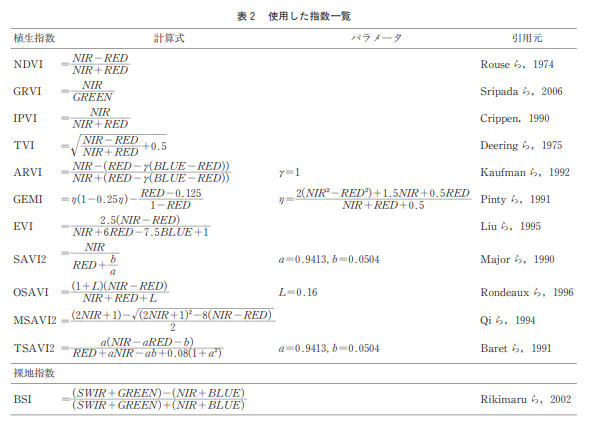  
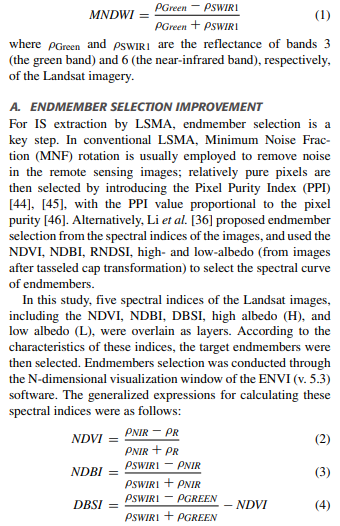  
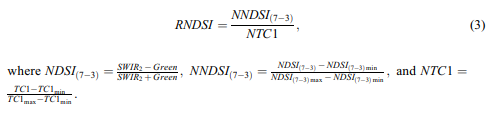

In [ ]:
'''
NDBI_resampling_S2A_54SVE_20200502_0_L2A_B11_crop.tif
UI_resampling_S2A_54SVE_20200502_0_L2A_B11_crop.tif
BA_resampling_S2A_54SVE_20200502_0_L2A_B11_crop.tif
NDVI_resampling_S2A_54SVE_20200502_0_L2A_B11_crop.tif
GNDVI_resampling_S2A_54SVE_20200502_0_L2A_B11_crop.tif
MSAVI2_resampling_S2A_54SVE_20200502_0_L2A_B11_crop.tif
MNDWI_resampling_S2A_54SVE_20200502_0_L2A_B11_crop.tif
NDWI_resampling_S2A_54SVE_20200502_0_L2A_B11_crop.tif
NDSI_resampling_S2A_54SVE_20200502_0_L2A_B11_crop.tif
BSI_resampling_S2A_54SVE_20200502_0_L2A_B11_crop.tif
DBSI_resampling_S2A_54SVE_20200502_0_L2A_B11_crop.tif 
'''

In [ ]:
# 各バンドのtifファイルのリスト
NDBI_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'NDBI_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
UI_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'UI_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
BA_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'BA_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
NDVI_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'NDVI_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
GNDVI_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'GNDVI_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
MSAVI2_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'MSAVI2_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
MNDWI_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'MNDWI_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
NDWI_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'NDWI_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
NDSI_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'NDSI_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
BSI_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'BSI_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
DBSI_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'DBSI_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
band_paths_list = NDBI_band_path_list_nomask + UI_band_path_list_nomask + BA_band_path_list_nomask + NDVI_band_path_list_nomask + GNDVI_band_path_list_nomask + MSAVI2_band_path_list_nomask + MNDWI_band_path_list_nomask + NDWI_band_path_list_nomask + NDSI_band_path_list_nomask + BSI_band_path_list_nomask + DBSI_band_path_list_nomask
display(band_paths_list)

In [ ]:
# ラスタデータのベクターデータのポリゴン範囲外の領域はマスクする処理を実施
# マスク後、ファイルとして保存
# maskの引数をcrop=Trueにしたらcropからmaskまで一気に実施してくれることを後で知った…
fig = plt.figure(figsize=(12, 16))
dim=len(band_paths_list)
for ix, rio_file in enumerate(band_paths_list):
    # ラスターファイルを開く
    with rio.open(rio_file) as src:
      # ラスターデータをベクターデータで切り抜く
      out_image, out_transform = mask(src, re_shape_tsukuba_mirai_2RasterCrs.geometry, crop=True, nodata=np.nan)
      out_meta = src.meta
      name = src.name
      bounds = src.bounds
    
    # メタ情報の更新
    out_meta.update({"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform,
                    'dtype':rio.float32})
    
    # マスク結果可視化
    #ax = plt.subplot(round(np.ceil(dim/np.sqrt(dim))), round(np.ceil(dim/np.sqrt(dim))), ix+1)
    ax = plt.subplot(11, 6, ix+1)

    satIndex = os.path.basename(name).split('_')[0]
    if satIndex=='NDBI' or satIndex=='UI' or satIndex=='BA':
        cmap = 'coolwarm'
    elif satIndex=='NDVI' or satIndex=='GNDVI' or satIndex=='MSAVI2':
        cmap = 'RdYlGn'
    elif satIndex=='MNDWI' or satIndex=='NDWI':
        cmap = 'Blues'
    elif satIndex=='NDSI' or satIndex=='BSI' or satIndex=='DBSI':
        cmap = 'PuOr_r'
    else:
        cmap = 'RdYlGn_r'
    img = ax.imshow(out_image[0], cmap=cmap, vmin=np.nanquantile(out_image[0], q=0.01), vmax=np.nanquantile(out_image[0], q=0.99), extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
    plt.setp(ax.get_xticklabels(), fontsize=4)
    plt.setp(ax.get_yticklabels(), fontsize=4)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    cbar = plt.colorbar(img, cax=cax)
    cbar.ax.tick_params(labelsize=4)
    re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.5, ax=ax, linewidth=0.5)
    ax.yaxis.offsetText.set_fontsize(4)
    ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_title(os.path.basename(name).split('_')[0]+'_'+'_'.join(os.path.basename(name).split('_')[-5:-1]), fontsize=4)
    ax.grid(False)
    
    # 画像の書き出し
    with rio.open(os.path.join(os.path.dirname(name), 'masked_'+os.path.basename(name)), "w", **out_meta) as dest:
      dest.write(out_image)
    
plt.tight_layout()
plt.show()

In [ ]:
# マスクする前のNDBI, NDVI, BAのTIFファイルリスト
# 各バンドのtifファイルのリスト
NDBI_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'NDBI_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
UI_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'UI_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
BA_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'BA_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
NDVI_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'NDVI_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
GNDVI_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'GNDVI_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
MSAVI2_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'MSAVI2_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
MNDWI_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'MNDWI_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
NDWI_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'NDWI_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
NDSI_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'NDSI_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
BSI_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'BSI_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
DBSI_band_path_list_nomask = sorted(list(glob.glob(os.path.join(s2Output,'DBSI_resampling_S2*.tif*'))), key=lambda x:(x.split('_54SVE_')[-1]))
band_paths_list = NDBI_band_path_list_nomask + UI_band_path_list_nomask + BA_band_path_list_nomask + NDVI_band_path_list_nomask + GNDVI_band_path_list_nomask + MSAVI2_band_path_list_nomask + MNDWI_band_path_list_nomask + NDWI_band_path_list_nomask + NDSI_band_path_list_nomask + BSI_band_path_list_nomask + DBSI_band_path_list_nomask
display(band_paths_list[2:][::6])

In [ ]:
def add_stats_vals(rio_data, vec_data, add_col_name, area_col='S_NAME'):
    affine = rio_data.transform
    mean_stats = rasterstats.zonal_stats(vec_data, rio_data.read(1)
                                         , affine=affine
                                         , add_stats={'mymean':lambda x: np.ma.mean(x)}) # np.ma.filled(x, fill_value=np.nan)
    mean_stats = [m['mymean'] for m in mean_stats]  # 平均値を取得
    vec_data_stats = vec_data#.copy()
    vec_data_stats[add_col_name] = mean_stats
    vec_data_stats[add_col_name] = vec_data_stats[add_col_name].map(lambda x: np.ma.filled(x, fill_value=np.nan))
    # 欠損値は小地域ごとの平均値で埋める
    category_means = vec_data_stats.dropna(subset=[add_col_name]).groupby(area_col)[add_col_name].mean()  # カテゴリごとの平均を計算
    vec_data_stats[add_col_name] = vec_data_stats[add_col_name].fillna(vec_data_stats[area_col].map(category_means))
    return vec_data_stats

if DOWNLOAD:
    ground_truth_2RasterCrs_concat_crop_exploded_stats = ground_truth_2RasterCrs_concat_crop_exploded.copy()
    for riofile in band_paths_list[2:][::6]:
        riodata = rio.open(riofile)
        ground_truth_2RasterCrs_concat_crop_exploded_stats = add_stats_vals(riodata
                                                                            , ground_truth_2RasterCrs_concat_crop_exploded_stats
                                                                            , os.path.basename(riofile).split('_')[0]+'_mean'
                                                                            , area_col='S_NAME')
    ground_truth_2RasterCrs_concat_crop_exploded_stats.to_file(os.path.join(shape_path, "ground_truth_2RasterCrs_concat_crop_exploded_stats.shp"), encoding="shift-jis")
    display(ground_truth_2RasterCrs_concat_crop_exploded_stats)

In [ ]:
# SHAPEファイルのカラム名は10文字以内の制限があるので、"MSAVI2_mean"は"MSAVI2_mea"になってしまっている
ground_truth_2RasterCrs_concat_crop_exploded_stats = gpd.read_file(os.path.join(shape_path, "ground_truth_2RasterCrs_concat_crop_exploded_stats.shp"), encoding="shift-jis")
ground_truth_2RasterCrs_concat_crop_exploded_stats.rename(columns={'MSAVI2_mea':'MSAVI2_mean'}, inplace=True)
display(ground_truth_2RasterCrs_concat_crop_exploded_stats)

In [ ]:
le = sklearn.preprocessing.LabelEncoder()
le_L03b_002 = le.fit_transform(ground_truth_2RasterCrs_concat_crop_exploded_stats['L03b_002'])
ground_truth_2RasterCrs_concat_crop_exploded_stats['le_L03b_002'] = le_L03b_002
ground_truth_2RasterCrs_concat_crop_exploded_stats

In [ ]:
area_use_categories_le = {j:area_use_categories[i] for i, j in zip(le.classes_, le.transform(le.classes_))}
display(area_use_categories)
display(area_use_categories_le)

In [ ]:
rio_file_list2020 = band_paths_list[2:][::6]
display(rio_file_list2020)

In [ ]:
fig = plt.figure(figsize=(6, 18))
num = 0
for i, file in tqdm(enumerate(rio_file_list2020)):
    riodata = rio.open(file)
    fname = os.path.basename(file)
    satIndex = fname.split('_')[0]
    if satIndex=='NDBI' or satIndex=='UI' or satIndex=='BA':
        cmap = 'coolwarm'
    elif satIndex=='NDVI' or satIndex=='GNDVI' or satIndex=='MSAVI2':
        cmap = 'RdYlGn'
    elif satIndex=='MNDWI' or satIndex=='NDWI':
        cmap = 'Blues'
    elif satIndex=='NDSI' or satIndex=='BSI' or satIndex=='DBSI':
        cmap = 'PuOr_r'
    else:
        cmap = 'RdYlGn_r'
        
    ax = plt.subplot(len(rio_file_list2020), 3, num+1)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    retted = show(riodata, ax=ax
                  , vmin=np.quantile(riodata.read(), 0.01)
                  , vmax=np.quantile(riodata.read(), 0.99)
                  , cmap=cmap)
    img = retted.get_images()[0]
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    cbar = plt.colorbar(img, cax=cax)
    cbar.ax.tick_params(labelsize=4, width=0.4, length=5)
    plt.setp(ax.get_xticklabels(), fontsize=4)
    plt.setp(ax.get_yticklabels(), fontsize=4)
    ax.set_title(fname.split('_')[0]+'_'+fname.split('_')[4]+'_RasterMap', fontsize=4)
    re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.2)
    ax.yaxis.offsetText.set_fontsize(4)
    ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(False)

    ax = plt.subplot(len(rio_file_list2020), 3, num+2)
    show(riodata, ax=ax
         , vmin=np.quantile(riodata.read(), 0.01)
         , vmax=np.quantile(riodata.read(), 0.99)
         , alpha=0.6, cmap='Greys_r')
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    img = ground_truth_2RasterCrs_concat_crop_exploded_stats.plot(column=satIndex+'_mean', cmap=cmap, edgecolor='k', legend=True, ax=ax, cax=cax
                                                                  , linewidth=0.05
                                                                  , vmin=np.nanquantile(ground_truth_2RasterCrs_concat_crop_exploded_stats[satIndex+'_mean'], 0.01)
                                                                  , vmax=np.nanquantile(ground_truth_2RasterCrs_concat_crop_exploded_stats[satIndex+'_mean'], 0.99)
                                                                  #, alpha=0.6
                                                                 )
    cax.tick_params(labelsize='4', width=0.4, length=5)
    plt.setp(ax.get_xticklabels(), fontsize=4)
    plt.setp(ax.get_yticklabels(), fontsize=4)
    ax.set_title(fname.split('_')[0]+'_'+fname.split('_')[4]+'_VectorMap', fontsize=4)
    # re_shape_tsukuba_mirai_2RasterCrs_NDBI.plot(facecolor='none', edgecolor='k', alpha=0.8, ax=ax, linewidth=0.2)
    ax.yaxis.offsetText.set_fontsize(4)
    ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(False)
    
    ax = plt.subplot(len(rio_file_list2020), 3, num+3)
    show(riodata, ax=ax
         , vmin=np.quantile(riodata.read(), 0.01)
         , vmax=np.quantile(riodata.read(), 0.99)
         , alpha=0.6, cmap='Greys_r')
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    img = ground_truth_2RasterCrs_concat_crop_exploded_stats.plot(column='le_L03b_002', cmap='tab10', edgecolor='k', legend=True, ax=ax, cax=cax
                                                                  , linewidth=0.05
                                                                  #, vmin=np.nanquantile(ground_truth_2RasterCrs_concat_crop_exploded_stats['NDBI_mean'], 0.01)
                                                                  #, vmax=np.nanquantile(ground_truth_2RasterCrs_concat_crop_exploded_stats['NDBI_mean'], 0.99)
                                                                  #, alpha=0.6
                                                                 )
    cax.tick_params(labelsize='4', width=0.4, length=5)
    plt.setp(ax.get_xticklabels(), fontsize=4)
    plt.setp(ax.get_yticklabels(), fontsize=4)
    ax.set_title(fname.split('_')[0]+'_'+fname.split('_')[4]+'_SoilCategory', fontsize=4)
    # re_shape_tsukuba_mirai_2RasterCrs_NDBI.plot(facecolor='none', edgecolor='k', alpha=0.8, ax=ax, linewidth=0.2)
    ax.yaxis.offsetText.set_fontsize(4)
    ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(False)
    num += 3
    
plt.tight_layout()
plt.show()

In [ ]:
satIndex='NDSI'
cmap='PuOr_r'
ground_truth_2RasterCrs_concat_crop_exploded_stats_2point = ground_truth_2RasterCrs_concat_crop_exploded_stats.copy()
ground_truth_2RasterCrs_concat_crop_exploded_stats_2point['geometry'] = [p.centroid for p in ground_truth_2RasterCrs_concat_crop_exploded_stats.geometry]
fig = plt.figure(figsize=(3, 3))
ax = plt.subplot(1,1,1)
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cax = divider.append_axes('right', '5%', pad='3%')
img = ground_truth_2RasterCrs_concat_crop_exploded_stats_2point.plot(column=satIndex+'_mean', cmap=cmap, edgecolor='k', legend=True, ax=ax, cax=cax
                                                                     , linewidth=0.05, markersize=2
                                                                     , vmin=np.quantile(ground_truth_2RasterCrs_concat_crop_exploded_stats[satIndex+'_mean'], 0.01)
                                                                     , vmax=np.quantile(ground_truth_2RasterCrs_concat_crop_exploded_stats[satIndex+'_mean'], 0.99)
                                                                    )
cax.tick_params(labelsize='4', width=0.4, length=5)
plt.setp(ax.get_xticklabels(), fontsize=4)
plt.setp(ax.get_yticklabels(), fontsize=4)
ax.set_title(satIndex, fontsize=4)
# re_shape_tsukuba_mirai_2RasterCrs_NDBI.plot(facecolor='none', edgecolor='k', alpha=0.8, ax=ax, linewidth=0.2)
ax.yaxis.offsetText.set_fontsize(4)
ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.grid(False)
plt.show()

In [ ]:
%%time
if DOWNLOAD:
    flood1 = gpd.read_file(os.path.join(shape_path, 'A31-22_10_5339_SHP', '20_想定最大規模', 'A31-20-22_10_5339.shp'), encoding='shift-jis')
    flood1 = flood1.to_crs(raster_crs.profile["crs"])
    flood1 = gpd.overlay(re_shape_tsukuba_mirai_2RasterCrs, flood1, how='intersection')  # クロップ
    flood2 = gpd.read_file(os.path.join(shape_path, 'A31-22_10_5340_SHP', '20_想定最大規模', 'A31-20-22_10_5340.shp'), encoding='shift-jis')
    flood2 = flood2.to_crs(raster_crs.profile["crs"])
    flood2 = gpd.overlay(re_shape_tsukuba_mirai_2RasterCrs, flood2, how='intersection')  # クロップ
    flood3 = gpd.read_file(os.path.join(shape_path, 'A31-22_10_5439_SHP', '20_想定最大規模', 'A31-20-22_10_5439.shp'), encoding='shift-jis')
    flood3 = flood3.to_crs(raster_crs.profile["crs"])
    flood3 = gpd.overlay(re_shape_tsukuba_mirai_2RasterCrs, flood3, how='intersection')  # クロップ
    flood4 = gpd.read_file(os.path.join(shape_path, 'A31-22_10_5440_SHP', '20_想定最大規模', 'A31-20-22_10_5440.shp'), encoding='shift-jis')
    flood4 = flood4.to_crs(raster_crs.profile["crs"])
    flood4 = gpd.overlay(re_shape_tsukuba_mirai_2RasterCrs, flood4, how='intersection')  # クロップ
    flood = pd.concat([flood1
                       , flood2
                       , flood3
                       , flood4]).reset_index(drop=True)
    flood = gpd.overlay(re_shape_tsukuba_mirai_2RasterCrs, flood, how='intersection')  # クロップ
    flood.to_file(os.path.join(shape_path, "flood.shp"), encoding="shift-jis")

In [ ]:
'''
# 洪水浸水想定区域（1次メッシュ単位）データ
flood = gpd.read_file(os.path.join(shape_path, "flood.shp"), encoding="shift-jis")
display(flood)
'''

In [ ]:
# flood_rank = {1:'0m以上0.5m未満', 2:'0.5m以上3.0m未満', 3:'3.0m以上5.0m未満', 4:'5.0m以上10.0m未満', 5:'10.0m以上20.0m未満', 6:'20.0m以上'}

In [ ]:
if DOWNLOAD:
    flood_stats = flood[['PREF_NAME_','CITY_NAME_','S_NAME_1','AREA_1','A31_201','geometry']].copy()
    for riofile in band_paths_list[2:][::6]:
        riodata = rio.open(riofile)
        flood_stats = add_stats_vals(riodata
                                     , flood_stats
                                     , os.path.basename(riofile).split('_')[0]+'_mean'
                                     , area_col='S_NAME_1')
    flood_stats.to_file(os.path.join(shape_path, "flood_stats.shp"), encoding="shift-jis")
    display(flood_stats)

In [ ]:
'''
# 洪水浸水想定区域（1次メッシュ単位）データ
flood_stats = gpd.read_file(os.path.join(shape_path, "flood_stats.shp"), encoding="shift-jis")
flood_stats.rename(columns={'MSAVI2_mea':'MSAVI2_mean'}, inplace=True)
flood_stats_2point = flood_stats.copy()
flood_stats_2point['geometry'] = [p.centroid for p in flood_stats_2point.geometry]
display(flood_stats_2point)
'''

In [ ]:
'''
plt.rcParams['font.family'] = prop.get_name() #全体のフォントを設定
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(2,2,1)
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cax = divider.append_axes('right', '5%', pad='3%')
img = flood.plot(column='A31_201', cmap='RdYlGn_r', edgecolor='k', legend=True, ax=ax, cax=cax, linewidth=0.05)
cax.tick_params(labelsize='4', width=0.4, length=5)
plt.setp(ax.get_xticklabels(), fontsize=4)
plt.setp(ax.get_yticklabels(), fontsize=4)
ax.set_title('洪水浸水想定区域 想定最大規模 Polygon', fontsize=4)
re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.8, ax=ax, linewidth=0.2)
ax.yaxis.offsetText.set_fontsize(4)
ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.grid(False)

ax = plt.subplot(2,2,2)
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cax = divider.append_axes('right', '5%', pad='3%')
img = flood_stats_2point.plot(column='A31_201', cmap='RdYlGn_r', edgecolor='k', legend=True, ax=ax, cax=cax, linewidth=0.05, markersize=1)
cax.tick_params(labelsize='4', width=0.4, length=5)
plt.setp(ax.get_xticklabels(), fontsize=4)
plt.setp(ax.get_yticklabels(), fontsize=4)
ax.set_title('洪水浸水想定区域 想定最大規模 Point', fontsize=4)
re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.8, ax=ax, linewidth=0.2)
ax.yaxis.offsetText.set_fontsize(4)
ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.grid(False)

ax = plt.subplot(2,2,3)
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cax = divider.append_axes('right', '5%', pad='3%')
img = flood_stats_2point.plot(column='NDVI_mean', cmap='RdYlGn', edgecolor='k', legend=True, ax=ax, cax=cax, linewidth=0.05, markersize=1)
cax.tick_params(labelsize='4', width=0.4, length=5)
plt.setp(ax.get_xticklabels(), fontsize=4)
plt.setp(ax.get_yticklabels(), fontsize=4)
ax.set_title('NDVI Point', fontsize=4)
re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.8, ax=ax, linewidth=0.2)
ax.yaxis.offsetText.set_fontsize(4)
ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.grid(False)

ax = plt.subplot(2,2,4)
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cax = divider.append_axes('right', '5%', pad='3%')
img = flood_stats_2point.plot(column='NDSI_mean', cmap='PuOr_r', edgecolor='k', legend=True, ax=ax, cax=cax, linewidth=0.05, markersize=1)
cax.tick_params(labelsize='4', width=0.4, length=5)
plt.setp(ax.get_xticklabels(), fontsize=4)
plt.setp(ax.get_yticklabels(), fontsize=4)
ax.set_title('NDSI Point', fontsize=4)
re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.8, ax=ax, linewidth=0.2)
ax.yaxis.offsetText.set_fontsize(4)
ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.grid(False)
plt.tight_layout()
plt.show()
'''

In [ ]:
explanatory_variables = ground_truth_2RasterCrs_concat_crop_exploded_stats_2point.filter(like='mean', axis=1).columns.to_list()
objective_variables = 'le_L03b_002'

In [ ]:
# split data
X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(ground_truth_2RasterCrs_concat_crop_exploded_stats_2point[explanatory_variables+['geometry']]
                                                                         , ground_truth_2RasterCrs_concat_crop_exploded_stats_2point[[objective_variables]+['geometry']]
                                                                         , test_size=0.92, shuffle=True, random_state=0
                                                                         , stratify=ground_truth_2RasterCrs_concat_crop_exploded_stats_2point[objective_variables])
print(X_train.shape, X_test.shape)

In [ ]:
display(y_train[objective_variables].value_counts())
display(y_test[objective_variables].value_counts())

In [ ]:
plt.rcParams['font.family'] = prop.get_name() #全体のフォントを設定
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1,2,1)
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cax = divider.append_axes('right', '5%', pad='3%')
img = y_train.plot(column=objective_variables, cmap='tab10', edgecolor='k', legend=True, ax=ax, cax=cax, linewidth=0.05, markersize=5)
cax.tick_params(labelsize='4', width=0.4, length=5)
plt.setp(ax.get_xticklabels(), fontsize=4)
plt.setp(ax.get_yticklabels(), fontsize=4)
ax.set_title('土壌分類 Point Train', fontsize=4)
re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.8, ax=ax, linewidth=0.2)
ax.yaxis.offsetText.set_fontsize(4)
ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.grid(False)

ax = plt.subplot(1,2,2)
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cax = divider.append_axes('right', '5%', pad='3%')
img = y_test.plot(column=objective_variables, cmap='tab10', edgecolor='k', legend=True, ax=ax, cax=cax, linewidth=0.05, markersize=1)
cax.tick_params(labelsize='4', width=0.4, length=5)
plt.setp(ax.get_xticklabels(), fontsize=4)
plt.setp(ax.get_yticklabels(), fontsize=4)
ax.set_title('土壌分類 Point Test', fontsize=4)
re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.8, ax=ax, linewidth=0.2)
ax.yaxis.offsetText.set_fontsize(4)
ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# 最近隣4ゾーンの計算して可視化する
# 重心（中心点）の計算
coords = X_train.centroid.map(lambda geom: (geom.x, geom.y)).tolist()
kd = libpysal.cg.KDTree(np.array(coords))
# 最近隣4ゾーンの計算
wnn2 = libpysal.weights.KNN(kd, 4)
# GeoDataFrameのプロット
fig = plt.figure(figsize=(2, 2))
ax = plt.subplot(1,1,1)
re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.2)
plt.setp(ax.get_xticklabels(), fontsize=4)
plt.setp(ax.get_yticklabels(), fontsize=4)
ax.set_title('最近隣4ゾーン', fontsize=4)
ax.yaxis.offsetText.set_fontsize(4)
ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# 近接行列のプロット
for i, (key, val) in enumerate(wnn2.neighbors.items()):
    for neighbor in val:
        ax.plot([coords[i][0], coords[neighbor][0]], [coords[i][1], coords[neighbor][1]], color='red', linewidth=0.1
                #, marker='+', markersize=0.001, markerfacecolor="k", markeredgecolor="k"
               )
ax.grid(False)
plt.show()

In [ ]:
# 損失関数に重みづけ
def sample_w(y_train):
    '''
    output sample weight (balanced weight)
    y_train:True Train data
    multip:重み調整
    '''
    n_samples=len(y_train)
    n_classes=len(np.unique(y_train))
    bincounts = {i:len(y_train[y_train==i]) for i in sorted(np.unique(y_train))}
    class_ratio_param = {key:n_samples / (n_classes * bincnt) for key, bincnt in bincounts.items()}
    #print('class_ratio_param',class_ratio_param)
    sample_weight=np.array([class_ratio_param[r] for r in y_train])
    return sample_weight
sample_ws = sample_w(y_train[objective_variables])

print(y_train[objective_variables].value_counts(),'\n')
lr = sklearn.linear_model.LogisticRegression(max_iter=1000)
lr.fit(X_train[explanatory_variables], y_train[objective_variables], sample_weight=sample_ws)
result_proba = lr.predict_proba(X_train[explanatory_variables])
result = lr.predict(X_train[explanatory_variables])
reslutDf = pd.DataFrame({'true':y_train[objective_variables].to_numpy(), 'pred':result.ravel()})
print(sklearn.metrics.classification_report(y_train[objective_variables].to_numpy(), result.ravel()),'\n')
cm = sklearn.metrics.confusion_matrix(y_train[objective_variables].to_numpy(), result.ravel())
print(cm,'\n\n######################################\n')

print(y_test[objective_variables].value_counts(),'\n')
result_proba = lr.predict_proba(X_test[explanatory_variables])
result = lr.predict(X_test[explanatory_variables])
reslutDf = pd.DataFrame({'true':y_test[objective_variables].to_numpy(), 'pred':result.ravel()})
print(sklearn.metrics.classification_report(y_test[objective_variables].to_numpy(), result.ravel()),'\n')
cm = sklearn.metrics.confusion_matrix(y_test[objective_variables].to_numpy(), result.ravel())
print(cm)

In [ ]:
import pymc as pm

In [ ]:
with pm.Model() as model:
    # coords(次元やインデックスを定義)
    model.add_coord('data', values=range(X_train.shape[0]), mutable=True)
    model.add_coord('var', values=explanatory_variables, mutable=True)
    model.add_coord('obj_var', values=sorted(y_train[objective_variables].unique()), mutable=True)
        
    # 説明変数
    x = pm.MutableData('x', X_train[explanatory_variables].to_numpy(), dims=('data', 'var'))
    y = pm.MutableData("y", y_train[objective_variables].to_numpy(), dims=('data', ))
    weights = pm.MutableData("weights", sample_ws, dims=('data', ))
    
    # 推論パラメータの事前分布
    coef_ = pm.Normal('coef', mu=0.0, sigma=1, dims=("var",'obj_var'))  # 各係数の事前分布は正規分布
    intercept_ = pm.Normal('intercept', mu=0.0, sigma=1.0, dims=("obj_var", ))  # 切片の事前分布は正規分布
    # linear model
    mu = pm.Deterministic("mu", x.dot(coef_)+intercept_, dims=('data', 'obj_var'))
    # y_pred = pm.OrderedLogistic("y_pred", cutpoints=cutpoints, eta=mu, observed=y)
    theta = pm.Deterministic("theta", pm.math.softmax(mu, axis=1), dims=('data', 'obj_var'))  # axis設定しないとダメ
    #y_pred = pm.Categorical("y_pred", p=theta, observed=y, dims='data')
    y_pred = pm.Potential('y_pred', (weights * pm.logp(pm.Categorical.dist(p=theta), y)).sum(axis=0), dims='data')
    
# モデル構造
modeldag = pm.model_to_graphviz(model)
display(modeldag)

In [ ]:
# CPU Multi
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

import jax
print(jax.default_backend())
print(jax.devices("cpu"))

In [ ]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model:
    # MCMCによる推論
    trace_org = pm.sample(draws=3000, tune=1000, chains=3, nuts_sampler="numpyro", random_seed=1, return_inferencedata=True)

In [ ]:
model_dir = 'content/drive/MyDrive/satelite/model'
os.makedirs(model_dir, exist_ok=True)
# データの保存 to_netcdfの利用
trace_org.to_netcdf(os.path.join(model_dir, 'model_GLM.nc'))

In [ ]:
model_dir = 'content/drive/MyDrive/satelite/model'
os.makedirs(model_dir, exist_ok=True)
# データの読み込み from_netcdfの利用
trace_org = az.from_netcdf(os.path.join(model_dir, 'model_GLM.nc'))

In [ ]:
import arviz as az

In [ ]:
# plot_trace
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, var_names=["coef","intercept"])
plt.show()

In [ ]:
# MCMCの収束を評価
rhat_vals = az.rhat(trace).values()

In [ ]:
# 最大のRhatを確認
result = np.max([np.max(i.values) for i in rhat_vals if i.name in ['coef','intercept','mu','theta']])
print('Max rhat:', result)
# 1.1以上のRhatを確認
for i in rhat_vals:
    if np.max(i.values)>=1.1:
        print(i.name, np.max(i.values), np.mean(i.values), i.values.shape, sep='  ====>  ')

In [ ]:
# 各クラスの事後確率theta
softmax_result = pd.DataFrame(trace['posterior']['theta'].mean(dim=["chain", "draw"]).values)
y_pred = softmax_result.idxmax(axis=1)
print(sklearn.metrics.classification_report(y_train[objective_variables].to_numpy(), y_pred.ravel()))
cm = sklearn.metrics.confusion_matrix(y_train[objective_variables].to_numpy(), y_pred.ravel())
print(cm)

In [ ]:
from scipy.special import softmax
# trainデータへの適用
coefs = trace['posterior']['coef'].mean(dim=["chain", "draw"]).values
intercepts = trace['posterior']['intercept'].mean(dim=["chain", "draw"]).values
mu = X_train[explanatory_variables].to_numpy().dot(coefs) + intercepts  # 回帰式（係数と切片）
m = softmax(mu, axis=1)  # ソフトマックス関数に入れて一般化線形モデルへ
m_class = m.argmax(axis=1)  # 最も確率が高いクラスを所属クラスとする
print(sklearn.metrics.classification_report(y_train[objective_variables].to_numpy(), m_class.ravel()), '\n')
cm = sklearn.metrics.confusion_matrix(y_train[objective_variables].to_numpy(), m_class.ravel())
print(cm)

In [ ]:
# 事後分布から予測サンプルを生成
with model:
    idata = pm.sample_posterior_predictive(trace)

In [ ]:
# 未知データへの適用
from scipy.special import softmax
coefs = trace['posterior']['coef'].mean(dim=["chain", "draw"]).values
intercepts = trace['posterior']['intercept'].mean(dim=["chain", "draw"]).values
mu = X_test[explanatory_variables].to_numpy().dot(coefs) + intercepts
m = softmax(mu, axis=1)
m_class = m.argmax(axis=1)
print(sklearn.metrics.classification_report(y_test[objective_variables].to_numpy(), m_class.ravel()))
cm = sklearn.metrics.confusion_matrix(y_test[objective_variables].to_numpy(), m_class.ravel())
print(cm)

In [ ]:
import pytensor.tensor as pt
import pytensor

In [ ]:
# 隣接行列作成
adj = wnn2.to_adjlist()
adj_symmetry = np.zeros((len(y_train), len(y_train)))
for i, (focal, neighbor) in tqdm(enumerate(zip(adj['focal'],adj['neighbor']))):
    if (focal, neighbor) in wnn2.asymmetry():
        # 非対称の場合、お互いに1とする
        adj_symmetry[focal, neighbor] = adj_symmetry[neighbor, focal] = 1
        continue
    adj_symmetry[focal, neighbor] = adj_symmetry[neighbor, focal] = 1
print(adj_symmetry.shape)

In [ ]:
classK = sorted(y_train[objective_variables].unique())
K = len(classK)
print(K)

In [ ]:
with pm.Model() as model:
    # coords(次元やインデックスを定義)
    model.add_coord('data', values=range(X_train.shape[0]), mutable=True)
    model.add_coord('var', values=explanatory_variables, mutable=True)
    model.add_coord('obj_var', values=sorted(y_train[objective_variables].unique()), mutable=True)
    
    # 変数
    x = pm.MutableData('x', X_train[explanatory_variables].to_numpy(), dims=('data', 'var'))
    y = pm.MutableData("y", y_train[objective_variables].to_numpy(), dims=('data', ))
    weights = pm.MutableData("weights", sample_ws, dims=('data', ))
    # pm_adj_symmetry = pm.MutableData("adj_symmetry", adj_symmetry, dims=('data', 'data'))
    print('x shape', x.eval().shape)
    print('y shape', y.eval().shape)
    print('weights shape', weights.eval().shape)
    # print('pm_adj_symmetry shape', pm_adj_symmetry.eval().shape)
    # 分散
    sigma = pm.Uniform('sigma', lower=0, upper=100, dims=("obj_var", ))#pm.Exponential('sigma', 1)
    print('sigma shape', sigma.eval().shape)
    
    # 推論パラメータの事前分布
    coef_ = pm.Normal('coef', mu=0.0, sigma=1, dims=("var",'obj_var'))  # 各係数の事前分布は正規分布
    intercept_ = pm.Normal('intercept', mu=0.0, sigma=1.0, dims=("obj_var", ))  # 切片の事前分布は正規分布
    print('coef shape', coef_.eval().shape)
    print('intercept shape', intercept_.eval().shape)

    # ICAR
    # 空間相関の項は地域の数分あり、クラス別の際は分散sigmaで表現
    ICARs = pm.ICAR('z_car', W=adj_symmetry, sigma=1, dims=('data', ))
    print('ICAR type', ICARs.type)
    # linear model
    mu = pm.Deterministic("mu", x.dot(coef_)+intercept_+(ICARs.reshape((len(y.eval()), 1))*sigma), dims=('data', 'obj_var'))
    print('x.dot(coef_) shape', x.dot(coef_).eval().shape)
    print('ICARs*sigma type', (ICARs*sigma).type)
    theta = pm.Deterministic("theta", pm.math.softmax(mu, axis=1), dims=('data', 'obj_var'))  # axis設定しないとダメ
    #y_pred = pm.Categorical("y_pred", p=theta, observed=y, dims='data')
    y_pred = pm.Potential('y_pred', (weights * pm.logp(pm.Categorical.dist(p=theta), y)).sum(axis=0), dims=('data', ))
# モデル構造
modeldag = pm.model_to_graphviz(model)
display(modeldag)

In [ ]:
with pm.Model() as model:    
    # coords(次元やインデックスを定義)
    model.add_coord('data', values=range(X_train.shape[0]), mutable=True)
    model.add_coord('var', values=explanatory_variables, mutable=True)
    model.add_coord('obj_var', values=sorted(y_train[objective_variables].unique()), mutable=True)
    
    # 変数
    x = pm.MutableData('x', X_train[explanatory_variables].to_numpy(), dims=('data', 'var'))
    y = pm.MutableData("y", y_train[objective_variables].to_numpy(), dims=('data', ))
    weights = pm.MutableData("weights", sample_ws, dims=('data', ))
    # pm_adj_symmetry = pm.MutableData("adj_symmetry", adj_symmetry, dims=('data', 'data'))
    print('x shape', x.eval().shape)
    print('y shape', y.eval().shape)
    print('weights shape', weights.eval().shape)
    # print('pm_adj_symmetry shape', pm_adj_symmetry.eval().shape)
    # 分散
    sigma = pm.Uniform('sigma', lower=0, upper=100)#pm.Exponential('sigma', 1)
    print('sigma shape', sigma.eval().shape)
    
    # 推論パラメータの事前分布
    coef_ = pm.Normal('coef', mu=0.0, sigma=1, dims=("var",'obj_var'))  # 各係数の事前分布は正規分布
    intercept_ = pm.Normal('intercept', mu=0.0, sigma=1.0, dims=("obj_var", ))  # 切片の事前分布は正規分布
    print('coef shape', coef_.eval().shape)
    print('intercept shape', intercept_.eval().shape)
    
    # ICAR
    ICAR10s = [pm.ICAR('z_car'+str(i+1), W=adj_symmetry, sigma=1, dims=('data', )).reshape((len(y.eval()), 1)) for i, k in enumerate(classK)]
    ICAR10s = pm.math.concatenate(ICAR10s, axis=1)

    print('ICAR10s type', ICAR10s.type)
    # linear model
    mu = pm.Deterministic("mu", x.dot(coef_)+intercept_+(ICAR10s*sigma), dims=('data', 'obj_var'))
    print('x.dot(coef_) shape', x.dot(coef_).eval().shape)
    print('ICAR10s*sigma type', (ICAR10s*sigma).type)
    theta = pm.Deterministic("theta", pm.math.softmax(mu, axis=1), dims=('data', 'obj_var'))  # axis設定しないとダメ
    #y_pred = pm.Categorical("y_pred", p=theta, observed=y, dims='data')
    y_pred = pm.Potential('y_pred', (weights * pm.logp(pm.Categorical.dist(p=theta), y)).sum(axis=0), dims=('data', ))
# モデル構造
modeldag = pm.model_to_graphviz(model)
display(modeldag)

In [ ]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model:
    # MCMCによる推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, nuts_sampler="numpyro", random_seed=1, return_inferencedata=True, idata_kwargs={"log_likelihood": False})

In [ ]:
model_dir = 'content/drive/MyDrive/satelite/model'
os.makedirs(model_dir, exist_ok=True)
# データの保存 to_netcdfの利用
trace.to_netcdf(os.path.join(model_dir, 'model_ICAR10.nc'))

In [ ]:
model_dir = 'content/drive/MyDrive/satelite/model'
os.makedirs(model_dir, exist_ok=True)
# データの読み込み from_netcdfの利用
trace = az.from_netcdf(os.path.join(model_dir, 'model_ICAR10.nc'))

In [ ]:
%%time
# plot_trace
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, var_names=["coef","intercept"])#+['z_car'+str(i) for i in range(1,11)])
plt.show()

In [ ]:
%%time
# plot_trace
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, var_names=["coef","intercept"])#+['z_car'+str(i) for i in range(1,11)])
plt.show()

In [ ]:
import gc
# バイオリンプロット
png_path = 'content/drive/MyDrive/satelite/png/'
os.makedirs(png_path, exist_ok=True)
order=None
xlabel=None
ylabel=None
title=None
figsize=(30,30)
area_name = ground_truth_2RasterCrs_concat_crop_exploded_stats_2point.loc[X_train.index,:]['S_NAME'].to_list()
area_name = [n.split('大字')[-1]+str(i).zfill(3) for i, n in enumerate(area_name)]
skip=55
for k, node in enumerate(['z_car'+str(i+1) for i in classK]):
    softmax1 = trace['posterior'][node].mean(dim=["chain"]).values
    corf_df = pd.DataFrame(softmax1)
    corf_df.columns=area_name
    corf_df = corf_df[corf_df.mean(axis=0).sort_values().index.to_list()]
    fig_cnt = round(len(corf_df.columns)/len(corf_df.iloc[:,::skip].columns))+1
    plot_violin_cnt = len(corf_df.iloc[:,::skip].columns)
    plt.rcParams['font.family'] = prop.get_name()
    fig=plt.figure(figsize=figsize)
    for i in tqdm(range(fig_cnt)):
        ax1 = plt.subplot(round(np.ceil(fig_cnt/np.sqrt(fig_cnt))), round(np.ceil(fig_cnt/np.sqrt(fig_cnt))), i+1)
        sns.violinplot(data=corf_df.iloc[:,i*plot_violin_cnt:i*plot_violin_cnt+plot_violin_cnt], ax=ax1)#, scale='width'
        plt.setp(ax1.get_xticklabels(), rotation=20, fontsize=6)
        plt.setp(ax1.get_yticklabels(), fontsize=6)
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)
        ax1.set_title(title)
    plt.suptitle(node+' {}'.format(area_use_categories_le[k]), y=1.0)
    plt.tight_layout()
    plt.savefig(os.path.join(png_path, node+'_{}'.format(area_use_categories_le[k])+'.png'))
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()
    del corf_df, fig
    gc.collect()
gc.collect()

In [ ]:
pd.DataFrame(trace['posterior']['coef'].mean(dim=["chain"]).values.var(axis=0).T, columns=explanatory_variables)

In [ ]:
# 空間相関成分
ep_sigma = trace['posterior']['intercept'].mean(dim=["chain"]).values.var(axis=0)
tau = trace['posterior']['sigma'].mean(dim=["chain","draw"]).values
print('tau', tau)
print('sigma', ep_sigma)
space_component = tau / (tau + ep_sigma)
space_component = pd.DataFrame({'class':[area_use_categories_le[k] for k in classK], 'space_component_ratio':space_component})
display(space_component)

In [ ]:
corf_df

In [ ]:
import gc
# バイオリンプロット
png_path = 'content/drive/MyDrive/satelite/png/'
os.makedirs(png_path, exist_ok=True)
order=None
xlabel=None
ylabel=None
title=None
figsize=(4,2.5)
skip=55
for k, node in enumerate(classK):
    softmax1_org = trace_org['posterior']['coef'].mean(dim=["chain"]).values[:,:,k]
    softmax1 = trace['posterior']['coef'].mean(dim=["chain"]).values[:,:,k]
    corf_df_org = pd.DataFrame(softmax1_org)
    corf_df_org.columns=explanatory_variables
    corf_df_org['sigma'] = trace_org['posterior']['intercept'].mean(dim=["chain"]).values.var(axis=0)[k]
    corf_df_org['tau'] = np.nan
    corf_df_org_stack = corf_df_org.stack().reset_index()
    corf_df_org_stack['space_corr'] = 0
    corf_df_org_stack.columns=['id','col_name','coef','space_corr']
    corf_df = pd.DataFrame(softmax1)
    corf_df.columns=explanatory_variables
    corf_df['sigma'] = trace['posterior']['intercept'].mean(dim=["chain"]).values.var(axis=0)[k]
    corf_df['tau'] = trace['posterior']['sigma'].mean(dim=["chain"]).values
    corf_df_stack = corf_df.stack().reset_index()
    corf_df_stack['space_corr'] = 1
    corf_df_stack.columns=['id','col_name','coef','space_corr']
    corf_df_stack = pd.concat([corf_df_org_stack, corf_df_stack]).reset_index(drop=True)
    plt.rcParams['font.family'] = prop.get_name()
    fig=plt.figure(figsize=figsize)
    ax1 = plt.subplot(1,1,1)
    img = sns.violinplot(data=corf_df_stack, x='col_name', y='coef', hue="space_corr", split=True, inner="quart", density_norm='width', ax=ax1, linewidth=0.2)
    for i, col in enumerate(corf_df.columns):
        ax1.text(i, corf_df_org[col].mean(), round(corf_df_org[col].mean(),2), fontsize=4, ha="right", color="k")
        ax1.text(i, corf_df[col].mean(), round(corf_df[col].mean(),2), fontsize=4, ha="left", color="k")
    plt.setp(ax1.get_xticklabels(), rotation=20, fontsize=4)
    plt.setp(ax1.get_yticklabels(), fontsize=4)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_title(title)
    plt.suptitle(f'Class {node}'+' ('+area_use_categories_le[k]+r') coefficient & $\tau^{2}$', y=0.85, fontsize=4)
    handler, label = ax1.get_legend_handles_labels()
    ax1.legend(handler, ["GLM","ICAR"], fontsize=4, loc='upper left')
    plt.tight_layout()
    plt.show()
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()
    del corf_df_org, corf_df_org_stack, corf_df, corf_df_stack, fig
    gc.collect()
gc.collect()

In [ ]:
import gc
# バイオリンプロット
png_path = 'content/drive/MyDrive/satelite/png/'
os.makedirs(png_path, exist_ok=True)
order=None
xlabel=None
ylabel=None
title=None
for k, node in enumerate(['z_car'+str(i+1) for i in classK]):
    plot_icar = ground_truth_2RasterCrs_concat_crop_exploded_stats_2point.loc[X_train.index,:].copy()
    icar = trace['posterior'][node].mean(dim=["chain","draw"]).values
    plot_icar[node] = icar
    plt.rcParams['font.family'] = prop.get_name() #全体のフォントを設定
    fig = plt.figure(figsize=(3, 3))
    ax = plt.subplot(1,1,1)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    img = plot_icar.plot(column=node, cmap='RdYlBu_r', edgecolor='k', legend=True, ax=ax, cax=cax, linewidth=0.05, markersize=5)
    cax.tick_params(labelsize='4', width=0.4, length=5)
    plt.setp(ax.get_xticklabels(), fontsize=4)
    plt.setp(ax.get_yticklabels(), fontsize=4)
    ax.set_title(node+' '+area_use_categories_le[k], fontsize=4)
    re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.8, ax=ax, linewidth=0.2)
    ax.yaxis.offsetText.set_fontsize(4)
    ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(False)
    plt.show()
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()
    del plot_icar, fig
    gc.collect()
gc.collect()

In [ ]:
# del corf_df
gc.collect()

In [ ]:
%%time
# MCMCの収束を評価
rhat_vals = az.rhat(trace).values()

In [ ]:
# 最大のRhatを確認
result = np.max([np.max(i.values) for i in rhat_vals])# if i.name in ["coef","intercept",'z_car','mu','theta','sigma']])
print('Max rhat:', result)
# 1.1以上のRhatを確認
for i in rhat_vals:
    if np.max(i.values)>=1.1:
        print(i.name, np.max(i.values), np.mean(i.values), i.values.shape, sep='  ====>  ')

In [ ]:
# 最大のRhatを確認
result = np.max([np.max(i.values) for i in rhat_vals])# if i.name in ["coef","intercept",'mu','theta','sigma']+['z_car'+str(i+1) for i, k in enumerate(classK)]])
print('Max rhat:', result)
# 1.1以上のRhatを確認
for i in rhat_vals:
    if np.max(i.values)>=1.1:
        print(i.name, np.max(i.values), np.mean(i.values), i.values.shape, sep='  ====>  ')

In [ ]:
# 各クラスの事後確率theta
softmax_result = pd.DataFrame(trace['posterior']['theta'].mean(dim=["chain", "draw"]).values)
y_pred = softmax_result.idxmax(axis=1)
print(sklearn.metrics.classification_report(y_train[objective_variables].to_numpy(), y_pred.ravel()))
cm = sklearn.metrics.confusion_matrix(y_train[objective_variables].to_numpy(), y_pred.ravel())
print(cm)

In [ ]:
# 各クラスの事後確率theta
softmax_result = pd.DataFrame(trace['posterior']['theta'].mean(dim=["chain", "draw"]).values)
y_pred = softmax_result.idxmax(axis=1)
print(sklearn.metrics.classification_report(y_train[objective_variables].to_numpy(), y_pred.ravel()))
cm = sklearn.metrics.confusion_matrix(y_train[objective_variables].to_numpy(), y_pred.ravel())
print(cm)

In [ ]:
from scipy.special import softmax
# # trainデータへの適用
# coefs = trace['posterior']['coef'].mean(dim=["chain", "draw"]).values
# intercepts = trace['posterior']['intercept'].mean(dim=["chain", "draw"]).values
# mu = X_train[explanatory_variables].to_numpy().dot(coefs) + intercepts  # 回帰式（係数と切片）
# m = softmax(mu, axis=1)  # ソフトマックス関数に入れて一般化線形モデルへ
# m_class = m.argmax(axis=1)  # 最も確率が高いクラスを所属クラスとする
# print(sklearn.metrics.classification_report(y_train[objective_variables].to_numpy(), m_class.ravel()), '\n')
# cm = sklearn.metrics.confusion_matrix(y_train[objective_variables].to_numpy(), m_class.ravel())
# print(cm)

# trainデータへの適用2
#z_cars_arr = np.concatenate([trace['posterior']['z_car'+str(i+1)].mean(dim=["chain", "draw"]).values.reshape(-1,1) for i, k in enumerate(classK)], axis=1)  # 学習データの空間相関変数の計算
z_cars_arr = trace['posterior']['z_car'].mean(dim=["chain", "draw"]).values.reshape(-1,1)
sigma_arr = trace['posterior']['sigma'].mean(dim=["chain", "draw"]).values
coefs = trace['posterior']['coef'].mean(dim=["chain", "draw"]).values
intercepts = trace['posterior']['intercept'].mean(dim=["chain", "draw"]).values
mu = X_train[explanatory_variables].to_numpy().dot(coefs) + intercepts + (z_cars_arr * sigma_arr)  # 回帰式（係数と切片）と空間相関変数
print('z_cars_arr', z_cars_arr.shape)
print('sigma_arr', sigma_arr.shape)
print('coefs', coefs.shape)
print('intercepts', intercepts.shape)
print('mu', mu.shape)
m = softmax(mu, axis=1)  # ソフトマックス関数に入れて一般化線形モデルへ
m_class = m.argmax(axis=1)  # 最も確率が高いクラスを所属クラスとする
print(sklearn.metrics.classification_report(y_train[objective_variables].to_numpy(), m_class.ravel()))
cm = sklearn.metrics.confusion_matrix(y_train[objective_variables].to_numpy(), m_class.ravel())
print(cm)

In [ ]:
from scipy.special import softmax
# # trainデータへの適用
# coefs = trace['posterior']['coef'].mean(dim=["chain", "draw"]).values
# intercepts = trace['posterior']['intercept'].mean(dim=["chain", "draw"]).values
# mu = X_train[explanatory_variables].to_numpy().dot(coefs) + intercepts  # 回帰式（係数と切片）
# m = softmax(mu, axis=1)  # ソフトマックス関数に入れて一般化線形モデルへ
# m_class = m.argmax(axis=1)  # 最も確率が高いクラスを所属クラスとする
# print(sklearn.metrics.classification_report(y_train[objective_variables].to_numpy(), m_class.ravel()), '\n')
# cm = sklearn.metrics.confusion_matrix(y_train[objective_variables].to_numpy(), m_class.ravel())
# print(cm)

# trainデータへの適用2
z_cars_arr = np.concatenate([trace['posterior']['z_car'+str(i+1)].mean(dim=["chain", "draw"]).values.reshape(-1,1) for i, k in enumerate(classK)], axis=1)  # 学習データの空間相関変数の計算
sigma_arr = trace['posterior']['sigma'].mean(dim=["chain", "draw"]).values
coefs = trace['posterior']['coef'].mean(dim=["chain", "draw"]).values
intercepts = trace['posterior']['intercept'].mean(dim=["chain", "draw"]).values
mu = X_train[explanatory_variables].to_numpy().dot(coefs) + intercepts + (z_cars_arr * sigma_arr)  # 回帰式（係数と切片）と空間相関変数
print('z_cars_arr', z_cars_arr.shape)
print('sigma_arr', sigma_arr.shape)
print('coefs', coefs.shape)
print('intercepts', intercepts.shape)
print('mu', mu.shape)
m = softmax(mu, axis=1)  # ソフトマックス関数に入れて一般化線形モデルへ
m_class = m.argmax(axis=1)  # 最も確率が高いクラスを所属クラスとする
print(sklearn.metrics.classification_report(y_train[objective_variables].to_numpy(), m_class.ravel()))
cm = sklearn.metrics.confusion_matrix(y_train[objective_variables].to_numpy(), m_class.ravel())
print(cm)

In [ ]:
def point_plot(results, re_shape_tsukuba_mirai_2RasterCrs, linewidth=0.05, markersize=5, title='', vmin=-8, vmax=8):
    plt.rcParams['font.family'] = prop.get_name() #全体のフォントを設定
    fig = plt.figure(figsize=(9, 3))
    ax = plt.subplot(1,3,1)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    img = results.plot(column=objective_variables, cmap='tab10', edgecolor='k', legend=True, ax=ax, cax=cax, linewidth=linewidth, markersize=markersize)
    cax.tick_params(labelsize='4', width=0.4, length=5)
    plt.setp(ax.get_xticklabels(), fontsize=4)
    plt.setp(ax.get_yticklabels(), fontsize=4)
    ax.set_title(title+' Point True', fontsize=4)
    re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.8, ax=ax, linewidth=0.2)
    ax.yaxis.offsetText.set_fontsize(4)
    ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(False)
    
    ax = plt.subplot(1,3,2)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    img = results.plot(column='pred', cmap='tab10', edgecolor='k', legend=True, ax=ax, cax=cax, linewidth=linewidth, markersize=markersize)
    cax.tick_params(labelsize='4', width=0.4, length=5)
    plt.setp(ax.get_xticklabels(), fontsize=4)
    plt.setp(ax.get_yticklabels(), fontsize=4)
    ax.set_title(title+' Point Pred', fontsize=4)
    re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.8, ax=ax, linewidth=0.2)
    ax.yaxis.offsetText.set_fontsize(4)
    ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(False)
    
    ax = plt.subplot(1,3,3)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    img = results.plot(column='diff', cmap='coolwarm', edgecolor='k', legend=True, ax=ax, cax=cax, linewidth=linewidth, markersize=markersize, vmin=vmin, vmax=vmax)
    cax.tick_params(labelsize='4', width=0.4, length=5)
    plt.setp(ax.get_xticklabels(), fontsize=4)
    plt.setp(ax.get_yticklabels(), fontsize=4)
    ax.set_title(title+' Point 差分(True-Pred)', fontsize=4)
    re_shape_tsukuba_mirai_2RasterCrs.plot(facecolor='none', edgecolor='k', alpha=0.8, ax=ax, linewidth=0.2)
    ax.yaxis.offsetText.set_fontsize(4)
    ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(False)
    plt.tight_layout()
    plt.show()

In [ ]:
results = y_train.copy()
results['pred'] = y_pred.ravel()
results['diff'] = results[objective_variables]-results['pred']
point_plot(results, re_shape_tsukuba_mirai_2RasterCrs, linewidth=0.05, markersize=5, title='土壌分類', vmin=-8, vmax=8)

In [ ]:
results = y_train.copy()
results['pred'] = y_pred.ravel()
results['diff'] = results[objective_variables]-results['pred']
point_plot(results, re_shape_tsukuba_mirai_2RasterCrs, linewidth=0.05, markersize=5, title='土壌分類', vmin=-8, vmax=8)

In [ ]:
train_coord = pd.DataFrame({'x':X_train['geometry'].x.to_list(), 'y':X_train['geometry'].y.to_list()})
test_coord = pd.DataFrame({'x':X_test['geometry'].x.to_list(), 'y':X_test['geometry'].y.to_list()})
knn = sklearn.neighbors.NearestNeighbors(n_neighbors=5)
knn.fit(train_coord)
distances, indices = knn.kneighbors(test_coord)

In [ ]:
test_coord['indices'] = indices[:,0]
display(test_coord)

In [ ]:
# テストデータと最も近い学習データの空間相関変数を取得する
z_cars_arr = trace['posterior']['z_car'].mean(dim=["chain", "draw"]).values.reshape(-1,1)
z_cars_arr_test = z_cars_arr[list(indices[:,0]),:]  # テストデータと最も近い学習データの空間相関を各テストデータに対して計算
sigma_arr = trace['posterior']['sigma'].mean(dim=["chain", "draw"]).values
z_cars_arr_test = z_cars_arr_test * sigma_arr  # 分散をかける
print(z_cars_arr_test.shape)

In [ ]:
# テストデータと最も近い学習データの空間相関変数を取得する
z_cars_arr = np.concatenate([trace['posterior']['z_car'+str(i+1)].mean(dim=["chain", "draw"]).values.reshape(-1,1) for i, k in enumerate(classK)], axis=1)  # 学習データの空間相関変数の計算
z_cars_arr_test = z_cars_arr[list(indices[:,0]),:]  # テストデータと最も近い学習データの空間相関を各テストデータに対して計算
sigma_arr = trace['posterior']['sigma'].mean(dim=["chain", "draw"]).values
z_cars_arr_test = z_cars_arr_test * sigma_arr  # 分散をかける
print(z_cars_arr_test.shape)

In [ ]:
# 未知データへの適用
from scipy.special import softmax
coefs = trace['posterior']['coef'].mean(dim=["chain", "draw"]).values
intercepts = trace['posterior']['intercept'].mean(dim=["chain", "draw"]).values
mu = X_test[explanatory_variables].to_numpy().dot(coefs) + intercepts  # 回帰式（係数と切片）
m = softmax(mu, axis=1)  # ソフトマックス関数に入れて一般化線形モデルへ
m_class = m.argmax(axis=1)  # 最も確率が高いクラスを所属クラスとする
print(sklearn.metrics.classification_report(y_test[objective_variables].to_numpy(), m_class.ravel()), '\n')

# 未知データへの適用
from scipy.special import softmax
coefs = trace['posterior']['coef'].mean(dim=["chain", "draw"]).values
intercepts = trace['posterior']['intercept'].mean(dim=["chain", "draw"]).values
mu = X_test[explanatory_variables].to_numpy().dot(coefs) + intercepts + z_cars_arr_test  # 回帰式（係数と切片）と空間相関変数
m = softmax(mu, axis=1)  # ソフトマックス関数に入れて一般化線形モデルへ
m_class = m.argmax(axis=1)  # 最も確率が高いクラスを所属クラスとする
print(sklearn.metrics.classification_report(y_test[objective_variables].to_numpy(), m_class.ravel()))
cm = sklearn.metrics.confusion_matrix(y_test[objective_variables].to_numpy(), m_class.ravel())
print(cm)

In [ ]:
# 未知データへの適用
from scipy.special import softmax
coefs = trace['posterior']['coef'].mean(dim=["chain", "draw"]).values
intercepts = trace['posterior']['intercept'].mean(dim=["chain", "draw"]).values
mu = X_test[explanatory_variables].to_numpy().dot(coefs) + intercepts  # 回帰式（係数と切片）
m = softmax(mu, axis=1)  # ソフトマックス関数に入れて一般化線形モデルへ
m_class = m.argmax(axis=1)  # 最も確率が高いクラスを所属クラスとする
print(sklearn.metrics.classification_report(y_test[objective_variables].to_numpy(), m_class.ravel()), '\n')

# 未知データへの適用
from scipy.special import softmax
coefs = trace['posterior']['coef'].mean(dim=["chain", "draw"]).values
intercepts = trace['posterior']['intercept'].mean(dim=["chain", "draw"]).values
mu = X_test[explanatory_variables].to_numpy().dot(coefs) + intercepts + z_cars_arr_test  # 回帰式（係数と切片）と空間相関変数
m = softmax(mu, axis=1)  # ソフトマックス関数に入れて一般化線形モデルへ
m_class = m.argmax(axis=1)  # 最も確率が高いクラスを所属クラスとする
print(sklearn.metrics.classification_report(y_test[objective_variables].to_numpy(), m_class.ravel()))
cm = sklearn.metrics.confusion_matrix(y_test[objective_variables].to_numpy(), m_class.ravel())
print(cm)

In [ ]:
results = y_test.copy()
results['pred'] = m_class.ravel()
results['diff'] = results[objective_variables]-results['pred']
point_plot(results, re_shape_tsukuba_mirai_2RasterCrs, linewidth=0.05, markersize=1, title='土壌分類', vmin=-8, vmax=8)

In [ ]:
results = y_test.copy()
results['pred'] = m_class.ravel()
results['diff'] = results[objective_variables]-results['pred']
point_plot(results, re_shape_tsukuba_mirai_2RasterCrs, linewidth=0.05, markersize=1, title='土壌分類', vmin=-8, vmax=8)

In [ ]:
import optuna.integration.lightgbm as opt_lgb

In [ ]:
params = {'task': 'train',
          'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'metric': 'multi_logloss',
          'verbose': -1,
          'num_class': len(classK),
          'random_state': 0,  # 乱数シード
         }

lgb_train = opt_lgb.Dataset(X_train[explanatory_variables], y_train[objective_variables], weight=sample_ws)
skf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
# LightGBM学習
# CV使用Ver
tuner_cv = opt_lgb.LightGBMTunerCV(params, lgb_train
                                   , num_boost_round=1000
                                   , folds=skf
                                   , return_cvbooster=True
                                   , optuna_seed=0
                                   , callbacks=[opt_lgb.early_stopping(stopping_rounds=50, verbose=True)])

# 最適なパラメータを探索する
tuner_cv.run()
# 最も良かったスコアとパラメータを書き出す
print(f'Best score: {tuner_cv.best_score}')
print('Best params:')
print(tuner_cv.best_params)

In [ ]:
# LightGBMTunerCVでモデル作成時、n_splits数だけモデルができる
# すべてのモデルの結果の平均をとる関数
def cv_model_output(models, X_test):
    preds = []
    for mdl in models:
        pred = mdl.predict(X_test)
        preds.append(pred)
    pred = np.mean(np.array(preds), axis=0)
    return pred
models = tuner_cv.get_best_booster()
models = models.boosters
y_pred = cv_model_output(models, X_train[explanatory_variables].to_numpy())
m_class = y_pred.argmax(axis=1)  # 最も確率が高いクラスを所属クラスとする
print(sklearn.metrics.classification_report(y_train[objective_variables].to_numpy(), m_class.ravel()), '\n')
cm = sklearn.metrics.confusion_matrix(y_train[objective_variables].to_numpy(), m_class.ravel())
print(cm, '\n')

y_pred = cv_model_output(models, X_test[explanatory_variables].to_numpy())
m_class = y_pred.argmax(axis=1)  # 最も確率が高いクラスを所属クラスとする
print(sklearn.metrics.classification_report(y_test[objective_variables].to_numpy(), m_class.ravel()), '\n')
cm = sklearn.metrics.confusion_matrix(y_test[objective_variables].to_numpy(), m_class.ravel())
print(cm)

In [ ]:
results = y_test.copy()
results['pred'] = m_class.ravel()
results['diff'] = results[objective_variables]-results['pred']
point_plot(results, re_shape_tsukuba_mirai_2RasterCrs, linewidth=0.05, markersize=1, title='土壌分類', vmin=-8, vmax=8)